# CVD Risk Labeling

## Globorisk







  Arguments
sex:patient sex (0 = man, 1 = woman)

age:patient age (years)

sbp:systolic blood pressure (mmHg)

tc	: total cholesterol (mmol/L)

dm	: diabetes mellitus (0 = no, 1 = yes)

smk	: current smoker (0 = no, 1 = yes)

iso	:ISO code for country of interest
year: baseline year
time	follow up time (default is 10-years)
version	:calculator version, options are 'lab', 'office', or 'fatal'

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & utilities
from scipy.stats import chi2_contingency
from itertools import combinations
from copy import deepcopy

# R integration
import rpy2.robjects as robjects

# Scikit-learn: imputers
from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

# Scikit-learn: preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
)

# Scikit-learn: models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Scikit-learn: model selection & feature selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

# Scikit-learn: calibration
from sklearn.calibration import CalibratedClassifierCV

# Scikit-learn: metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

sd_clean = pd.read_csv("/content/drive/My Drive/STEPs survey data/final/sd.csv", encoding="utf-8")

In [7]:
# Keep only the specified columns in sd_clean
columns_to_keep = ['age', 'sex', 'DM', 'Total Cholesterol', 'current_smoker', 'avg_systolic', 'CVD History']
sd_clean = sd_clean[columns_to_keep].copy()

# Display the first few rows to verify the changes
print(sd_clean.head())

   age  sex  DM  Total Cholesterol  current_smoker  avg_systolic  CVD History
0   20    1   0              113.0             0.0     93.666667          0.0
1   23    1   0              100.0             0.0     87.000000          0.0
2   16    1   0              112.0             0.0    113.000000          0.0
3   24    1   0              100.0             0.0    109.000000          0.0
4   19    1   0              100.0             0.0    111.000000          0.0


##EDA

In [8]:
# ===============================
# GLOBAL STYLE SETTINGS
# ===============================
sns.set_theme(context="paper", style="white")
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.linewidth": 0.6,
})

# Variables
numerical_cols = ['age', 'Total Cholesterol', 'avg_systolic']
categorical_cols = ['sex', 'DM', 'current_smoker']

# Human-readable labels
feature_labels = {
    "age": "Age",
    "Total Cholesterol": "Total Cholesterol",
    "avg_systolic": "Average Systolic Blood Pressure",
    "sex": "Sex",
    "DM": "Diabetes Mellitus",
    "current_smoker": "Smoking Status"
}

# Category label mappings
label_maps = {
    "sex": {0: "Male", 1: "Female"},
    "DM": {0: "No", 1: "Yes"},
    "current_smoker": {0: "No", 1: "Yes"}
}

# Distinct colors for categorical vars
categorical_colors = {
    "sex": ["#4C72B0", "#DD8452"],           # blue / orange
    "DM": ["#55A868", "#C44E52"],            # green / red
    "current_smoker": ["#8172B3", "#937860"] # purple / brown
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

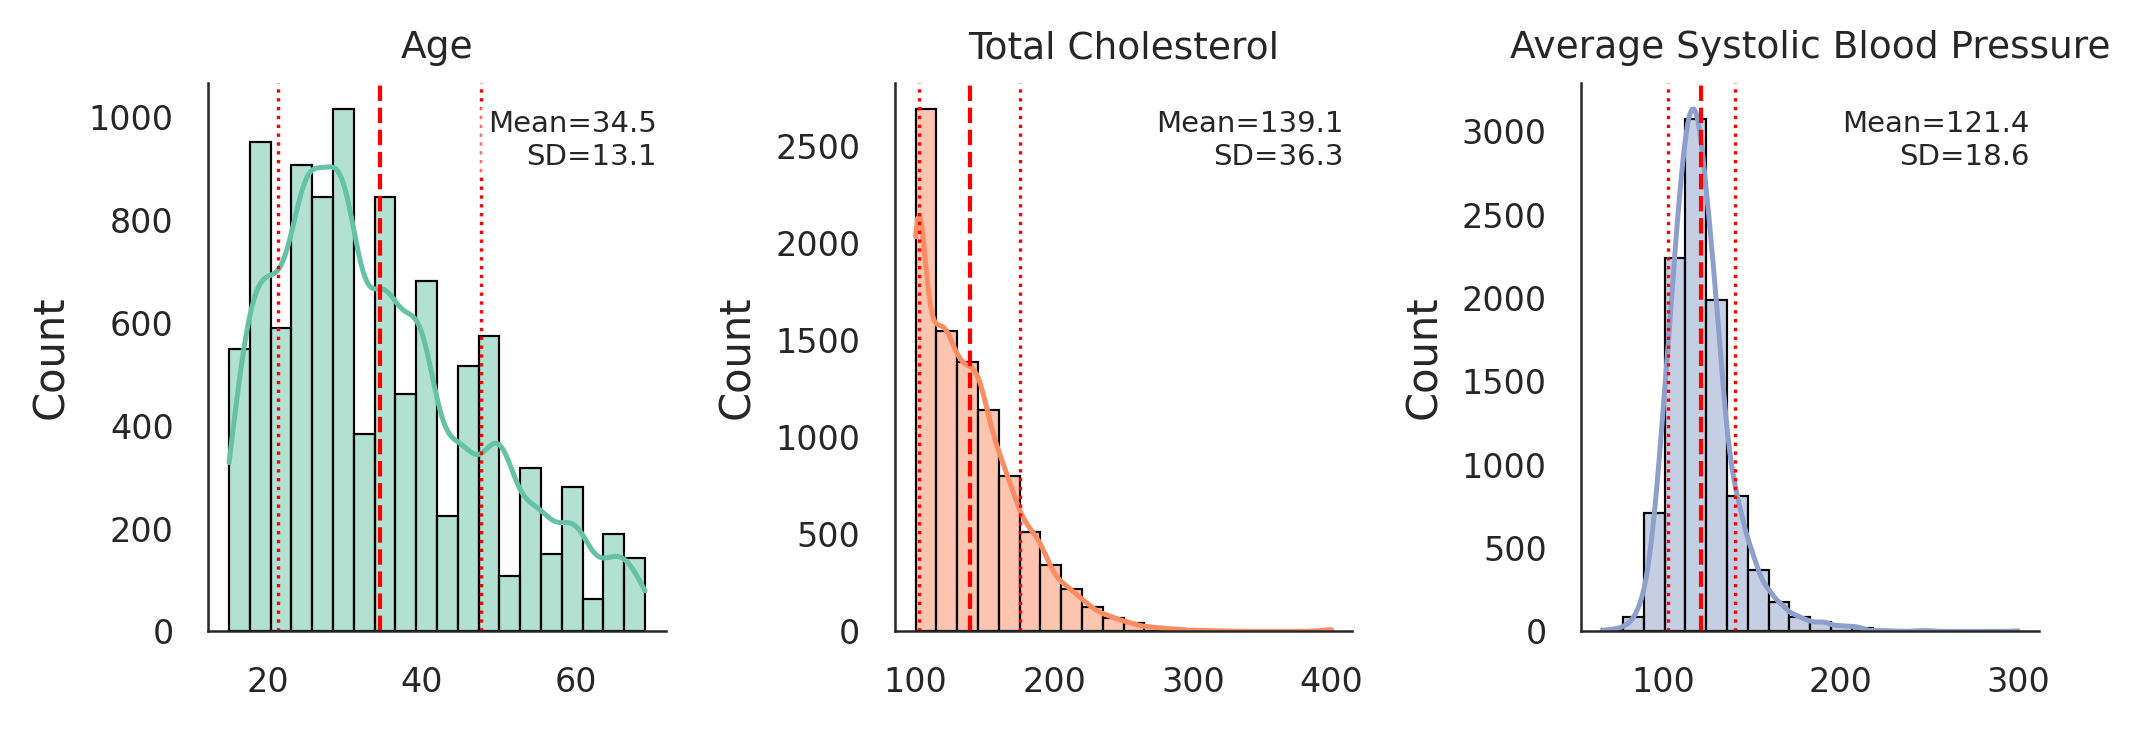

In [9]:
fig1, axes1 = plt.subplots(1, 3, figsize=(7, 2.5))  # wide but short row
axes1 = axes1.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes1[i]
    sns.histplot(sd_clean[col], bins=20, kde=True, ax=ax,
                 color=sns.color_palette("Set2")[i], edgecolor="black")

    # Mean ± SD
    mean_val = sd_clean[col].mean()
    sd_val = sd_clean[col].std()
    ax.axvline(mean_val, color="red", linestyle="--", linewidth=1)
    ax.axvline(mean_val + sd_val, color="red", linestyle=":", linewidth=0.8)
    ax.axvline(mean_val - sd_val, color="red", linestyle=":", linewidth=0.8)

    # Annotation
    ax.text(0.98, 0.95, f"Mean={mean_val:.1f}\nSD={sd_val:.1f}",
            transform=ax.transAxes, fontsize=7,
            ha="right", va="top",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.6))

    ax.set_title(feature_labels[col], fontsize=9)

    # Remove the variable name from the x-axis
    ax.set_xlabel('')

for ax in axes1:
    ax.grid(False)
    sns.despine(ax=ax)

#fig1.suptitle("Distribution of continuous variables", fontsize=10, y=1.05)
plt.tight_layout()
plt.savefig("continuous_vars.png", dpi=300, bbox_inches="tight")
plt.savefig("continuous_vars.pdf", bbox_inches="tight")
# Download to PC
from google.colab import files

files.download("continuous_vars.pdf")

plt.show()

In [11]:
# count if age >=40

count_over_40 = sd_clean[sd_clean['age'] <40].shape[0]
count_over_40

6552

In [13]:
 #changing total cholstrol value from mg/dl to mmol/l,  tchol_mmol = total coholstrol * 0.02586.

# Calculate tchol_mmol
sd_clean['tchol_mmol'] = sd_clean['Total Cholesterol'] * 0.02586


In [14]:
# adding vars for the package, add column called type with string "risk", add column version with string "lab', year= 2020, iso "ETH"

sd_clean['type'] = 'risk'
sd_clean['version'] = 'lab'
sd_clean['year'] = 2020
sd_clean['iso'] = 'ETH'


In [18]:
import rpy2.robjects as robjects

# Ensure R dependencies are installed
robjects.r('''
if (!requireNamespace("remotes", quietly = TRUE)) install.packages("remotes")
remotes::install_github("boyercb/globorisk") # Changed repository owner to 'boyercb'
library(globorisk)
''')

# Access the function from globorisk
globorisk_r = robjects.r['globorisk']  # Replace 'function_name' with 'globorisk'

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpZpH9o2/remotes26529b4987b/boyercb-globorisk-af8322e/DESCRIPTION’ ... OK
* preparing ‘globorisk’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘globorisk_1.0.2.tar.gz’



(as ‘lib’ is unspecified)



In [20]:

# Load the globorisk library in the R environment
robjects.r('library(globorisk)')

# Access the 'r_function' from the globorisk package in R
globorisk_r = robjects.r['globorisk']  # Replace 'r_function' with the actual function name



In [22]:
sd_clean.shape

(9800, 12)

In [23]:
def calculate_globo_risk(row):
    return globorisk_r(
       sex=row['sex'],
        age=row['age'],
        sbp=row['avg_systolic'],
        tc=row['tchol_mmol'],
        dm=row['DM'],
        smk=row['current_smoker'],
        iso=row['iso'],
        year=row['year'],
        version=row['version'],
        type = 'risk'
   )

sd_clean.loc[(sd_clean['age'] >= 40) & (sd_clean['CVD History'] == 0), 'cvd_risk_score_globo'] = \
    sd_clean.loc[(sd_clean['age'] >= 40) & (sd_clean['CVD History'] == 0)].apply(calculate_globo_risk, axis=1)



In [25]:
sd_clean.to_csv("/content/drive/My Drive/STEPs survey data/final/sd_clean_globorisk.csv", encoding="utf-8", index=False)

In [26]:
sd_clean = pd.read_csv("/content/drive/My Drive/STEPs survey data/final/sd_clean_globorisk.csv", encoding="utf-8")

In [27]:
print(sd_clean['cvd_risk_score_globo'].unique())  # Check unique values in the 'age' column


[nan '[1] 0.007710376\n' '[1] 0.004238468\n' ... '[1] 0.04941141\n'
 '[1] 0.05011049\n' '[1] 0.05106622\n']


In [28]:
import re

sd_clean['cvd_risk_score_globo'] = sd_clean['cvd_risk_score_globo'].apply(
    lambda x: float(re.sub(r'\[.*?\]', '', str(x)).strip())
)

In [29]:
print(sd_clean['cvd_risk_score_globo'].unique())  # Check unique values in the 'age' column


[       nan 0.00771038 0.00423847 ... 0.04941141 0.05011049 0.05106622]


In [30]:
sd_clean['cvd_risk_score_globo'] = pd.to_numeric(sd_clean['cvd_risk_score_globo'], errors='coerce')

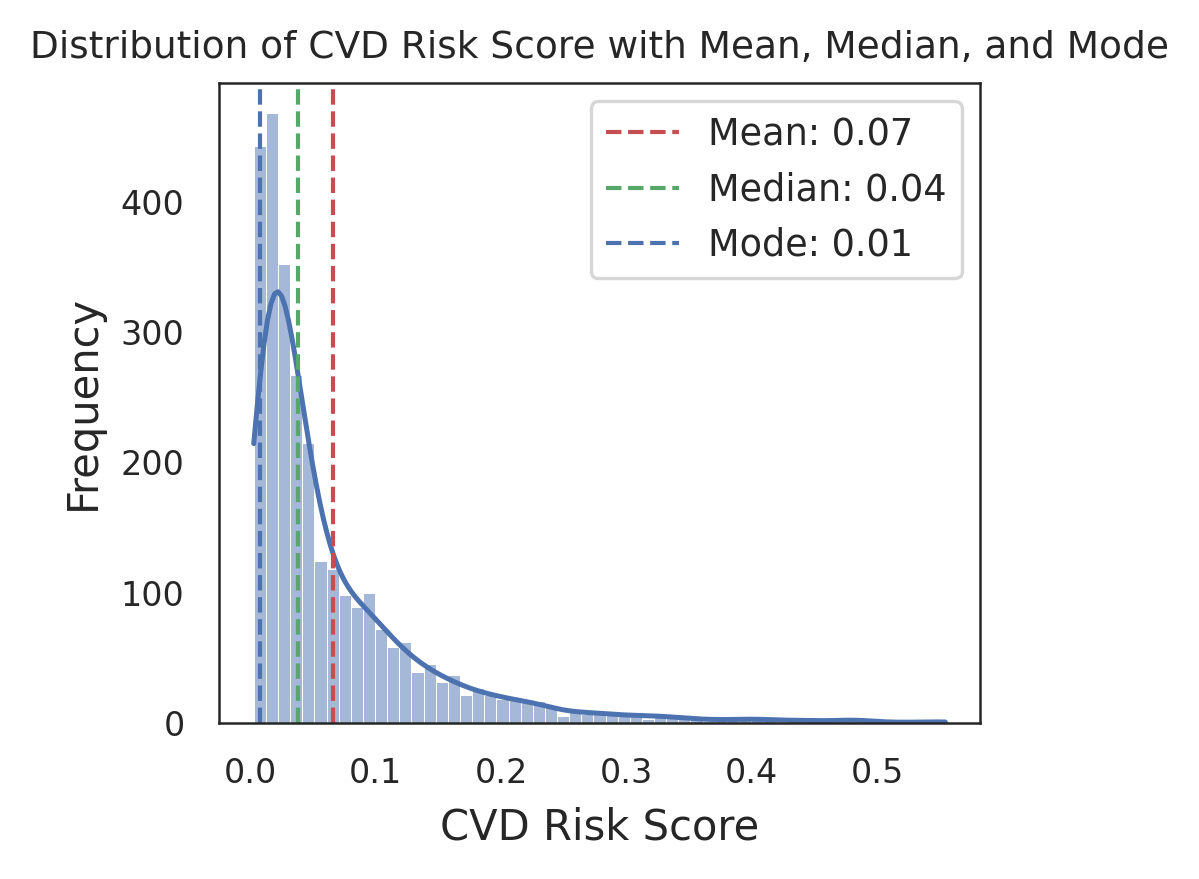

In [31]:
# plot cvd_risk_score_globo, mean median mode and box and whisker

# Calculate mean, median, and mode
mean_risk = sd_clean['cvd_risk_score_globo'].mean()
median_risk = sd_clean['cvd_risk_score_globo'].median()
mode_risk = sd_clean['cvd_risk_score_globo'].mode()[0]  # Access the first mode value

# Create the plot
plt.figure(figsize=(6, 3))

# Box and Whisker plot
#plt.subplot(1, 2, 1)
#sns.boxplot(y=sd_clean['cvd_risk_score_globo'])
#plt.title('Box Plot of CVD Risk Score')
#plt.ylabel('CVD Risk Score')

# Distribution plot with mean, median, and mode lines
plt.subplot(1, 2, 1)
sns.histplot(sd_clean['cvd_risk_score_globo'], kde=True)
plt.axvline(mean_risk, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_risk:.2f}')
plt.axvline(median_risk, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_risk:.2f}')
plt.axvline(mode_risk, color='b', linestyle='dashed', linewidth=1, label=f'Mode: {mode_risk:.2f}')
plt.title('Distribution of CVD Risk Score with Mean, Median, and Mode')
plt.xlabel('CVD Risk Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


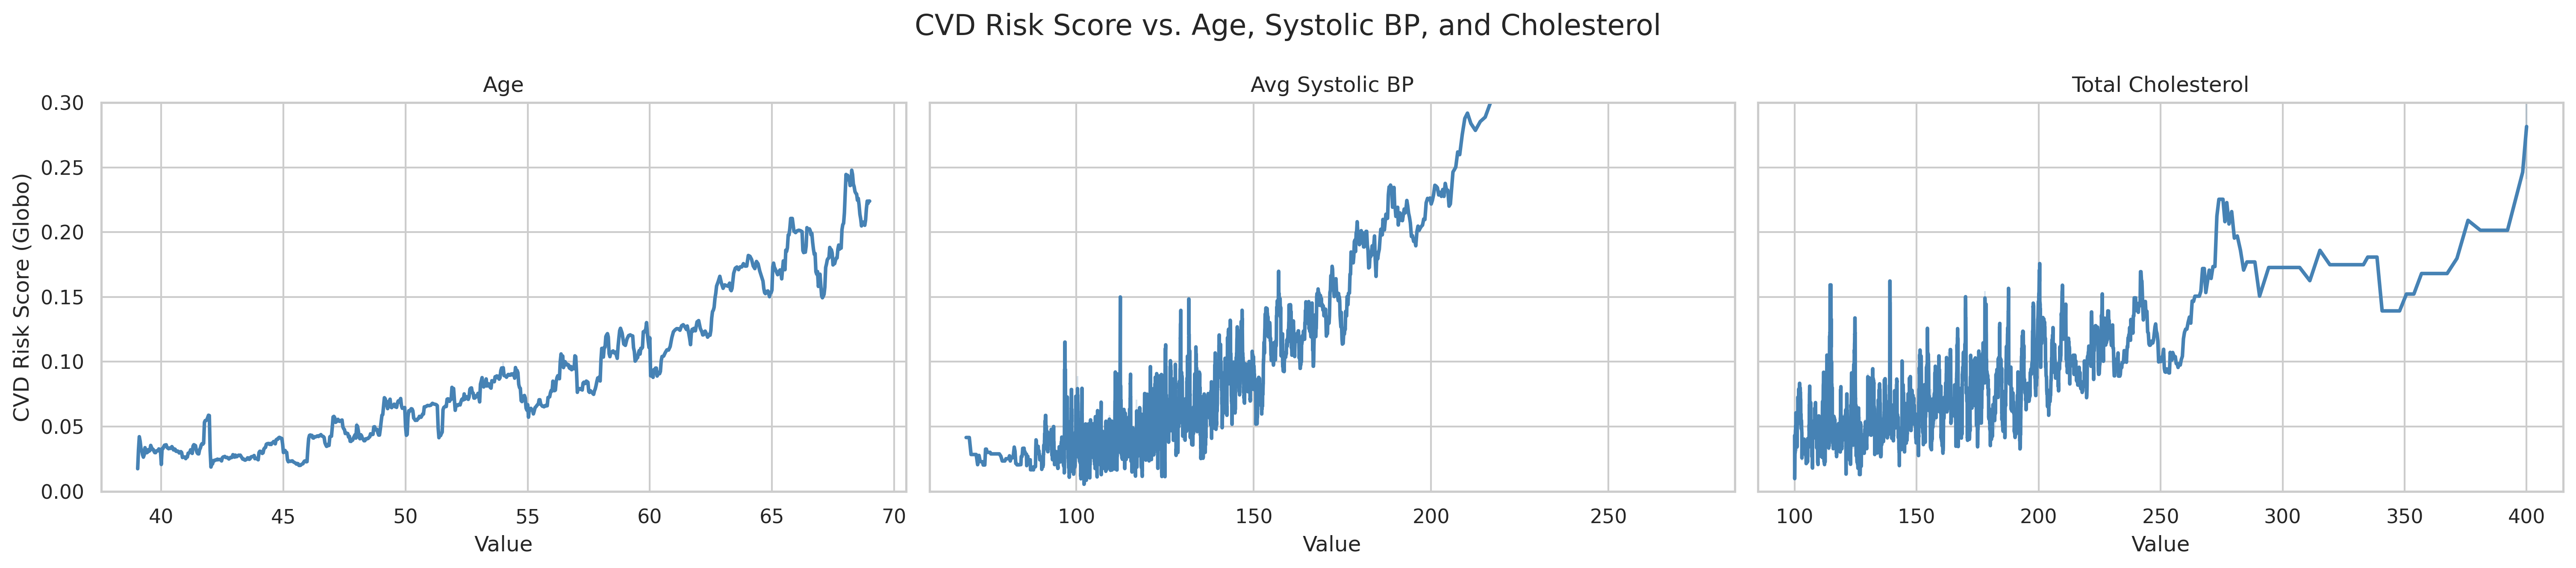

In [32]:
# Set seaborn style
sns.set(style='whitegrid')

# Apply rolling average to smooth each variable's data
age_df = (
    sd_clean[['age', 'cvd_risk_score_globo']]
    .sort_values('age')
    .rolling(window=30, min_periods=1)
    .mean()
    .assign(Variable='Age')
    .rename(columns={'age': 'Value'})
)

systolic_df = (
    sd_clean[['avg_systolic', 'cvd_risk_score_globo']]
    .sort_values('avg_systolic')
    .rolling(window=30, min_periods=1)
    .mean()
    .assign(Variable='Avg Systolic BP')
    .rename(columns={'avg_systolic': 'Value'})
)

cholesterol_df = (
    sd_clean[['Total Cholesterol', 'cvd_risk_score_globo']]
    .sort_values('Total Cholesterol')
    .rolling(window=30, min_periods=1)
    .mean()
    .assign(Variable='Total Cholesterol')
    .rename(columns={'Total Cholesterol': 'Value'})
)

# Combine all into a single DataFrame
sd_melt_facet = pd.concat([age_df, systolic_df, cholesterol_df])

# Create FacetGrid plot
g = sns.FacetGrid(
    sd_melt_facet,
    col="Variable",
    sharex=False,
    sharey=True,
    height=4.5,
    aspect=1.5,
    despine=False
)

g.map_dataframe(sns.lineplot, x="Value", y="cvd_risk_score_globo", color="steelblue", linewidth=2)

# Set axis labels and titles
g.set_axis_labels("Value", "CVD Risk Score (Globo)")
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 0.3))  # consistent y-axis scale

# Add main title
plt.subplots_adjust(top=0.85)
g.fig.suptitle("CVD Risk Score vs. Age, Systolic BP, and Cholesterol", fontsize=16)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


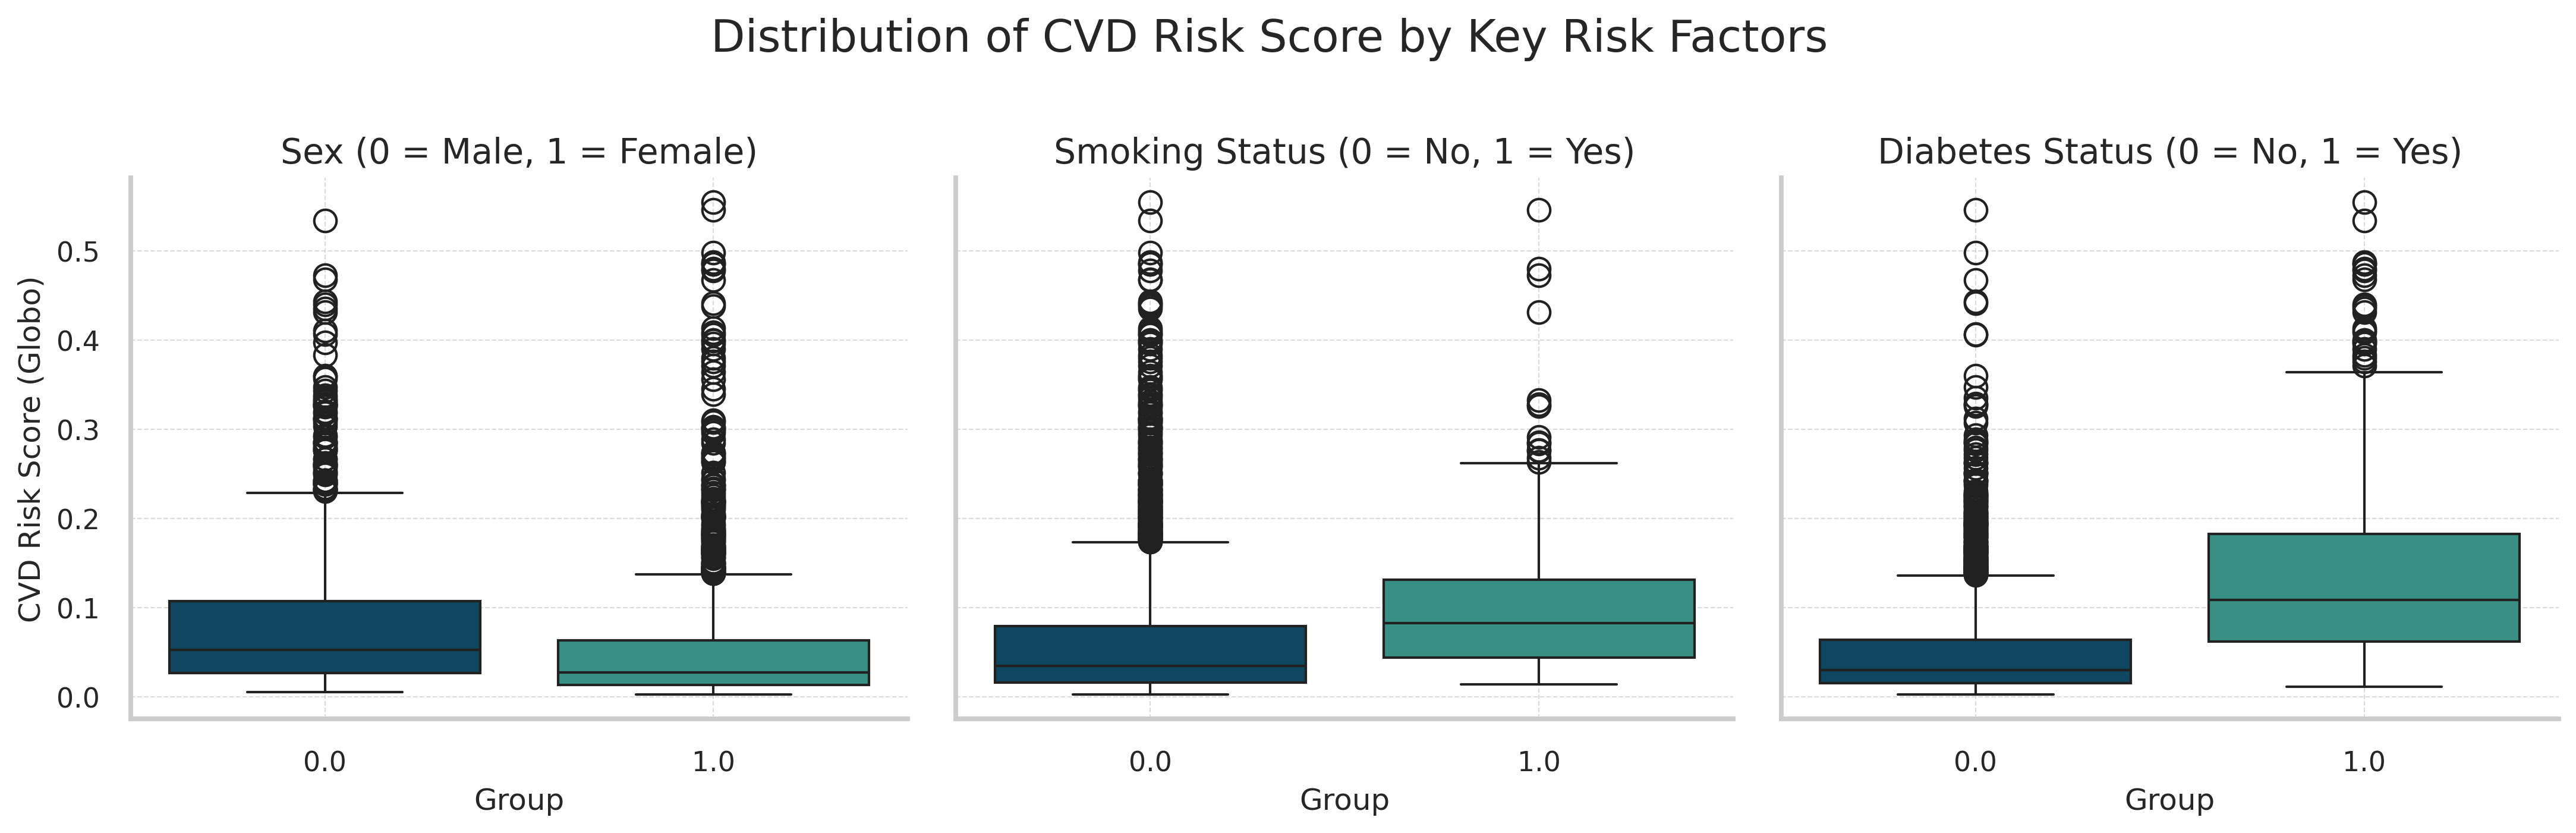

In [33]:

# Set style
sns.set(style='whitegrid', context='talk')

# Reshape the data to long format for FacetGrid
sd_long = pd.melt(
    sd_clean,
    id_vars='cvd_risk_score_globo',
    value_vars=['sex', 'current_smoker', 'DM'],
    var_name='Risk Factor',
    value_name='Group'
)

# Replace variable names and group codes for better readability
label_map = {
    'sex': 'Sex (0 = Male, 1 = Female)',
    'current_smoker': 'Smoking Status (0 = No, 1 = Yes)',
    'DM': 'Diabetes Status (0 = No, 1 = Yes)'
}
sd_long['Risk Factor'] = sd_long['Risk Factor'].map(label_map)

# Define custom color palette (dark blue and green)
custom_palette = ['#004c6d', '#2a9d8f']

# Create the FacetGrid (side-by-side layout)
g = sns.FacetGrid(
    sd_long,
    col='Risk Factor',
    col_wrap=3,  # side-by-side
    sharey=True,
    height=5,
    aspect=1
)

# Map boxplot to the grid
g.map_dataframe(
    sns.boxplot,
    x='Group',
    y='cvd_risk_score_globo',
    palette=custom_palette
)

# Customize each subplot
for ax, title in zip(g.axes.flatten(), sd_long['Risk Factor'].unique()):
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Group', fontsize=12)
    ax.set_ylabel('CVD Risk Score (Globo)', fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.tick_params(labelsize=11)

# Set overall title
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Distribution of CVD Risk Score by Key Risk Factors', fontsize=18)

plt.show()


##Binning cvd score to cvd risk

In [34]:
sd_clean.head()
sd_clean_cvd = sd_clean.copy()

In [ ]:

# Multiply the 'cvd_score_ss' column by 100
sd_clean_cvd['cvd_risk_percent_globo'] = sd_clean_cvd['cvd_risk_score_globo']* 100


In [ ]:
#Low Risk (<5%)
#elivated (≥5%)

# Create a categorical variable for CVD risk classification

# Define the bin edges and labels
bins = [-float('inf'), 5, float('inf')]  # Boundaries for risk groups
labels = [0,1]

# Create the categorical column
sd_clean_cvd['cvd_risk_cat_g'] = pd.cut(sd_clean_cvd['cvd_risk_percent_globo'], bins=bins, labels=labels)


In [37]:
# Raw count
print(sd_clean_cvd['cvd_risk_cat_g'].value_counts())

# Relative frequency (percentage)
print(sd_clean_cvd['cvd_risk_cat_g'].value_counts(normalize=True) * 100)


cvd_risk_cat_g
0    1716
1    1156
Name: count, dtype: int64
cvd_risk_cat_g
0    59.749304
1    40.250696
Name: proportion, dtype: float64


In [39]:
sd_clean_cvd.shape

(9800, 15)

In [40]:
print(sd_clean_cvd.columns.tolist())

['age', 'sex', 'DM', 'Total Cholesterol', 'current_smoker', 'avg_systolic', 'CVD History', 'tchol_mmol', 'type', 'version', 'year', 'iso', 'cvd_risk_score_globo', 'cvd_risk_percent_globo', 'cvd_risk_cat_g']


/tmp/ipython-input-959898359.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


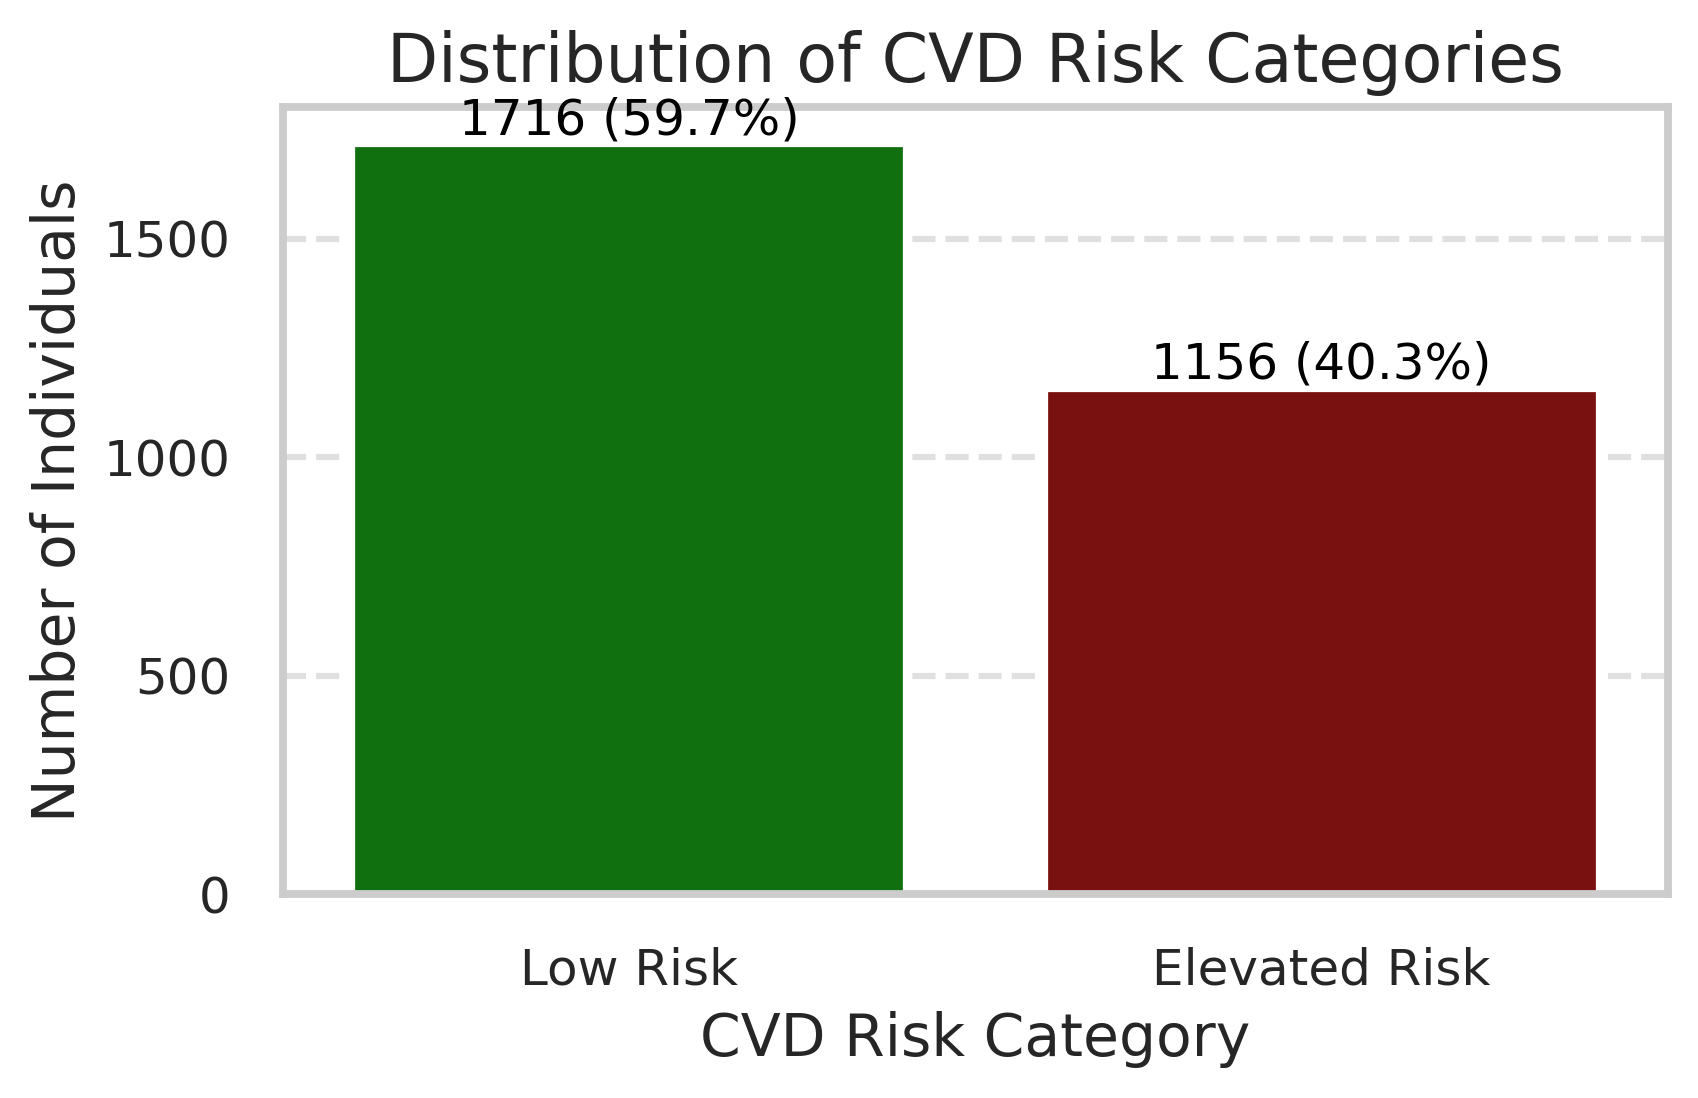

In [41]:
# Mapping for better label readability
label_map = {0: 'Low Risk', 1: 'Elevated Risk'}
sd_clean_cvd['cvd_risk_cat_g_label'] = sd_clean_cvd['cvd_risk_cat_g'].map(label_map)

# Count and percentage
risk_counts = sd_clean_cvd['cvd_risk_cat_g_label'].value_counts().sort_index()
risk_percent = (risk_counts / risk_counts.sum()) * 100

# Plotting
plt.figure(figsize=(6, 4))
bar_colors = ['green', 'darkred']

sns.barplot(
    x=risk_counts.index,
    y=risk_counts.values,
    palette=bar_colors
)

# Annotate with count and percentage
for i, (count, percent) in enumerate(zip(risk_counts.values, risk_percent.values)):
    plt.text(i, count + 1, f'{count} ({percent:.1f}%)',
             ha='center', va='bottom', fontsize=12, color='black')

# Labels and styling
plt.title('Distribution of CVD Risk Categories', fontsize=16)
plt.xlabel('CVD Risk Category', fontsize=14)
plt.ylabel('Number of Individuals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## validating globorisk using WHO

In [43]:
validation_df

,sex,age,avg_systolic,tchol_mmol,DM,current_smoker,cvd_risk_score_globo,cvd_risk_percent_globo,cvd_risk_cat_g
0,1,40,133.000000,4.24104,1,0.0,0.043280,4.328038,0
1,1,49,110.333333,3.43938,0,0.0,0.014902,1.490181,0
2,1,40,113.666667,2.92218,0,0.0,0.005439,0.543880,0
3,0,40,128.000000,3.10320,0,0.0,0.014494,1.449439,0
4,1,42,114.666667,3.72384,0,0.0,0.009231,0.923091,0
...,...,...,...,...,...,...,...,...,...
95,0,59,106.333333,2.58600,0,0.0,0.052025,5.202532,1
96,0,65,106.666667,4.31862,0,0.0,0.101794,10.179390,1
97,0,69,159.333333,4.91340,0,0.0,0.276887,27.688720,1
98,0,59,147.333333,3.77556,0,0.0,0.120043,12.004280,1


In [44]:
from google.colab import files
validation_df.to_excel('validation_df.xlsx', index=False)
files.download('validation_df.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:

WHO_validation_df = pd.read_excel("/content/drive/My Drive/STEPs survey data/WHO_validation_df.xlsx")
#print(WHO_validation_df.head())


In [46]:
WHO_validation_df

,sex,age,avg_systolic,tchol_mmol,DM,current_smoker,cvd_risk_score_globo,cvd_risk_percent_globo,cvd_risk_cat_g,WHO %,w
0,1,40,121,5.30130,0,0,0.013092,1.309179,0,1,0
1,1,43,126,3.77556,0,0,0.013093,1.309276,0,1,0
2,1,40,107,3.85314,0,0,0.006305,0.630508,0,1,0
3,1,40,115,4.08588,0,0,0.007981,0.798056,0,1,0
4,1,40,128,3.82728,0,0,0.009630,0.963049,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
94,0,65,129,3.23250,0,1,0.160967,16.096720,1,10,1
95,0,65,109,2.63772,0,1,0.113129,11.312870,1,8,1
96,1,65,142,5.17200,0,1,0.238409,23.840950,1,12,1
97,1,66,211,4.75824,0,1,0.544107,54.410700,1,22,1


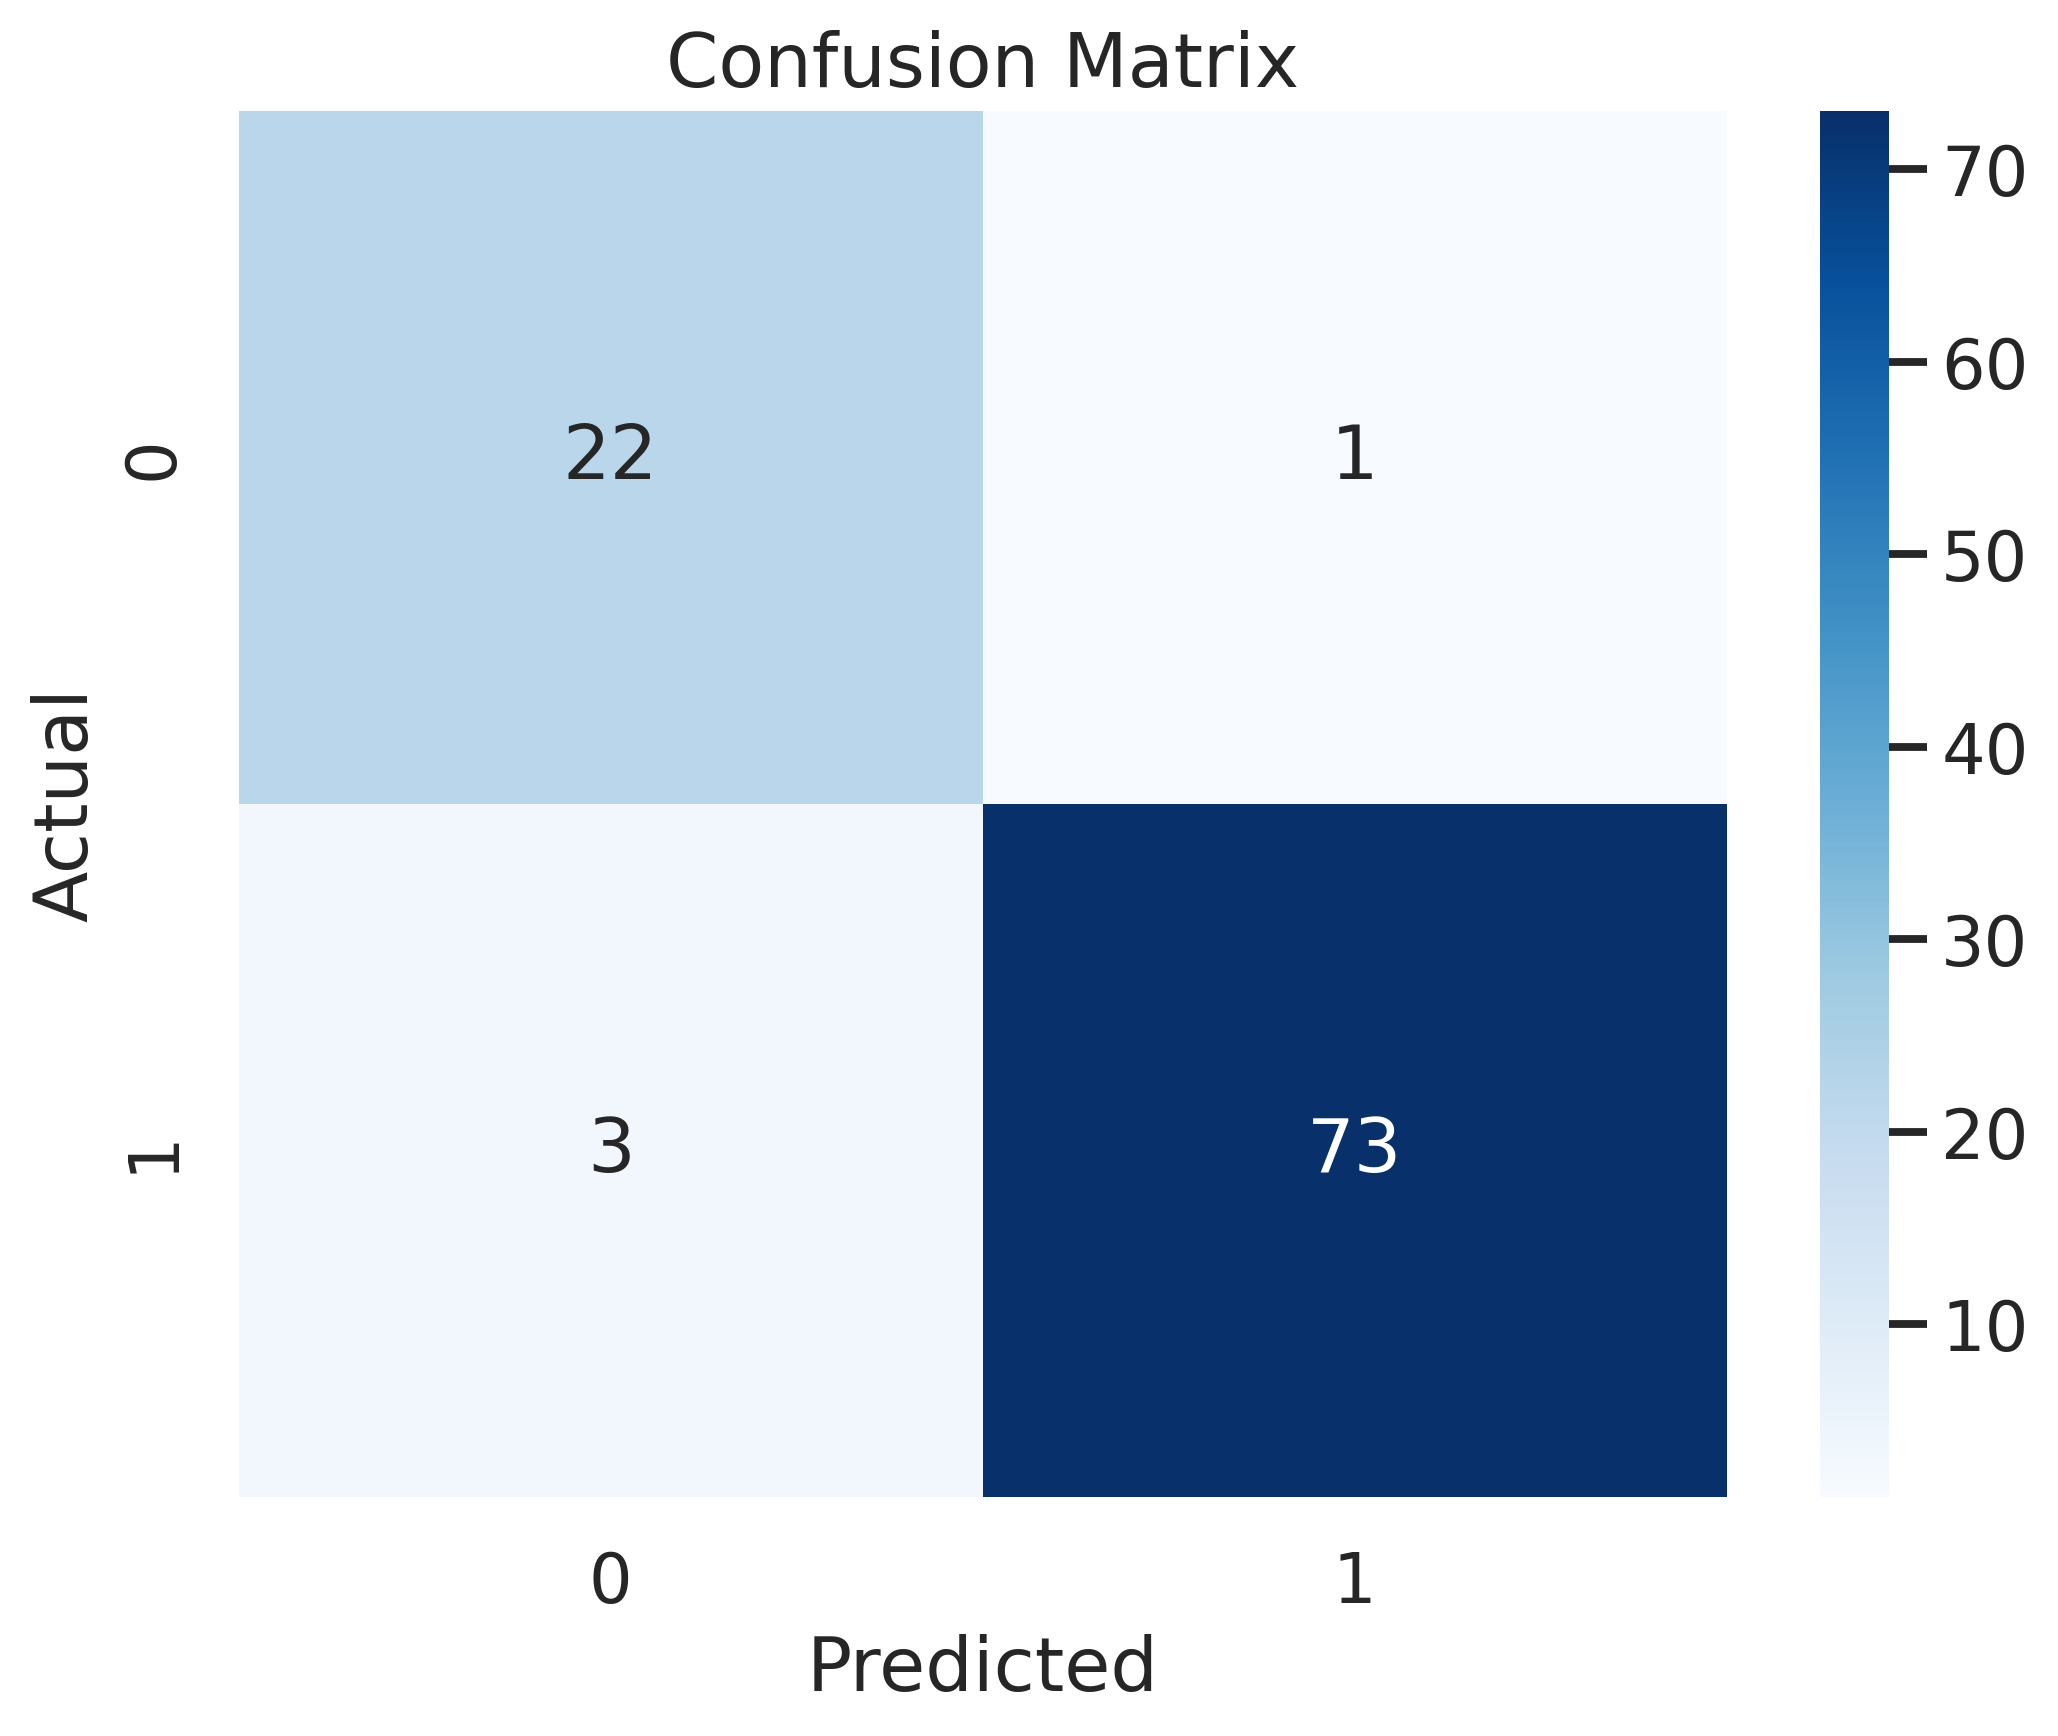

In [49]:
# Create  confusion matrix
cm = confusion_matrix(WHO_validation_df['cvd_risk_cat_g'], WHO_validation_df['w'])

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=WHO_validation_df['cvd_risk_cat_g'].unique(),
            yticklabels=WHO_validation_df['w'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [50]:
# Print the classification report
print(classification_report(WHO_validation_df['cvd_risk_cat_g'], WHO_validation_df['w']))



              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.99      0.96      0.97        76

    accuracy                           0.96        99
   macro avg       0.93      0.96      0.95        99
weighted avg       0.96      0.96      0.96        99



Sensitivity: 0.96
Specificity: 0.96


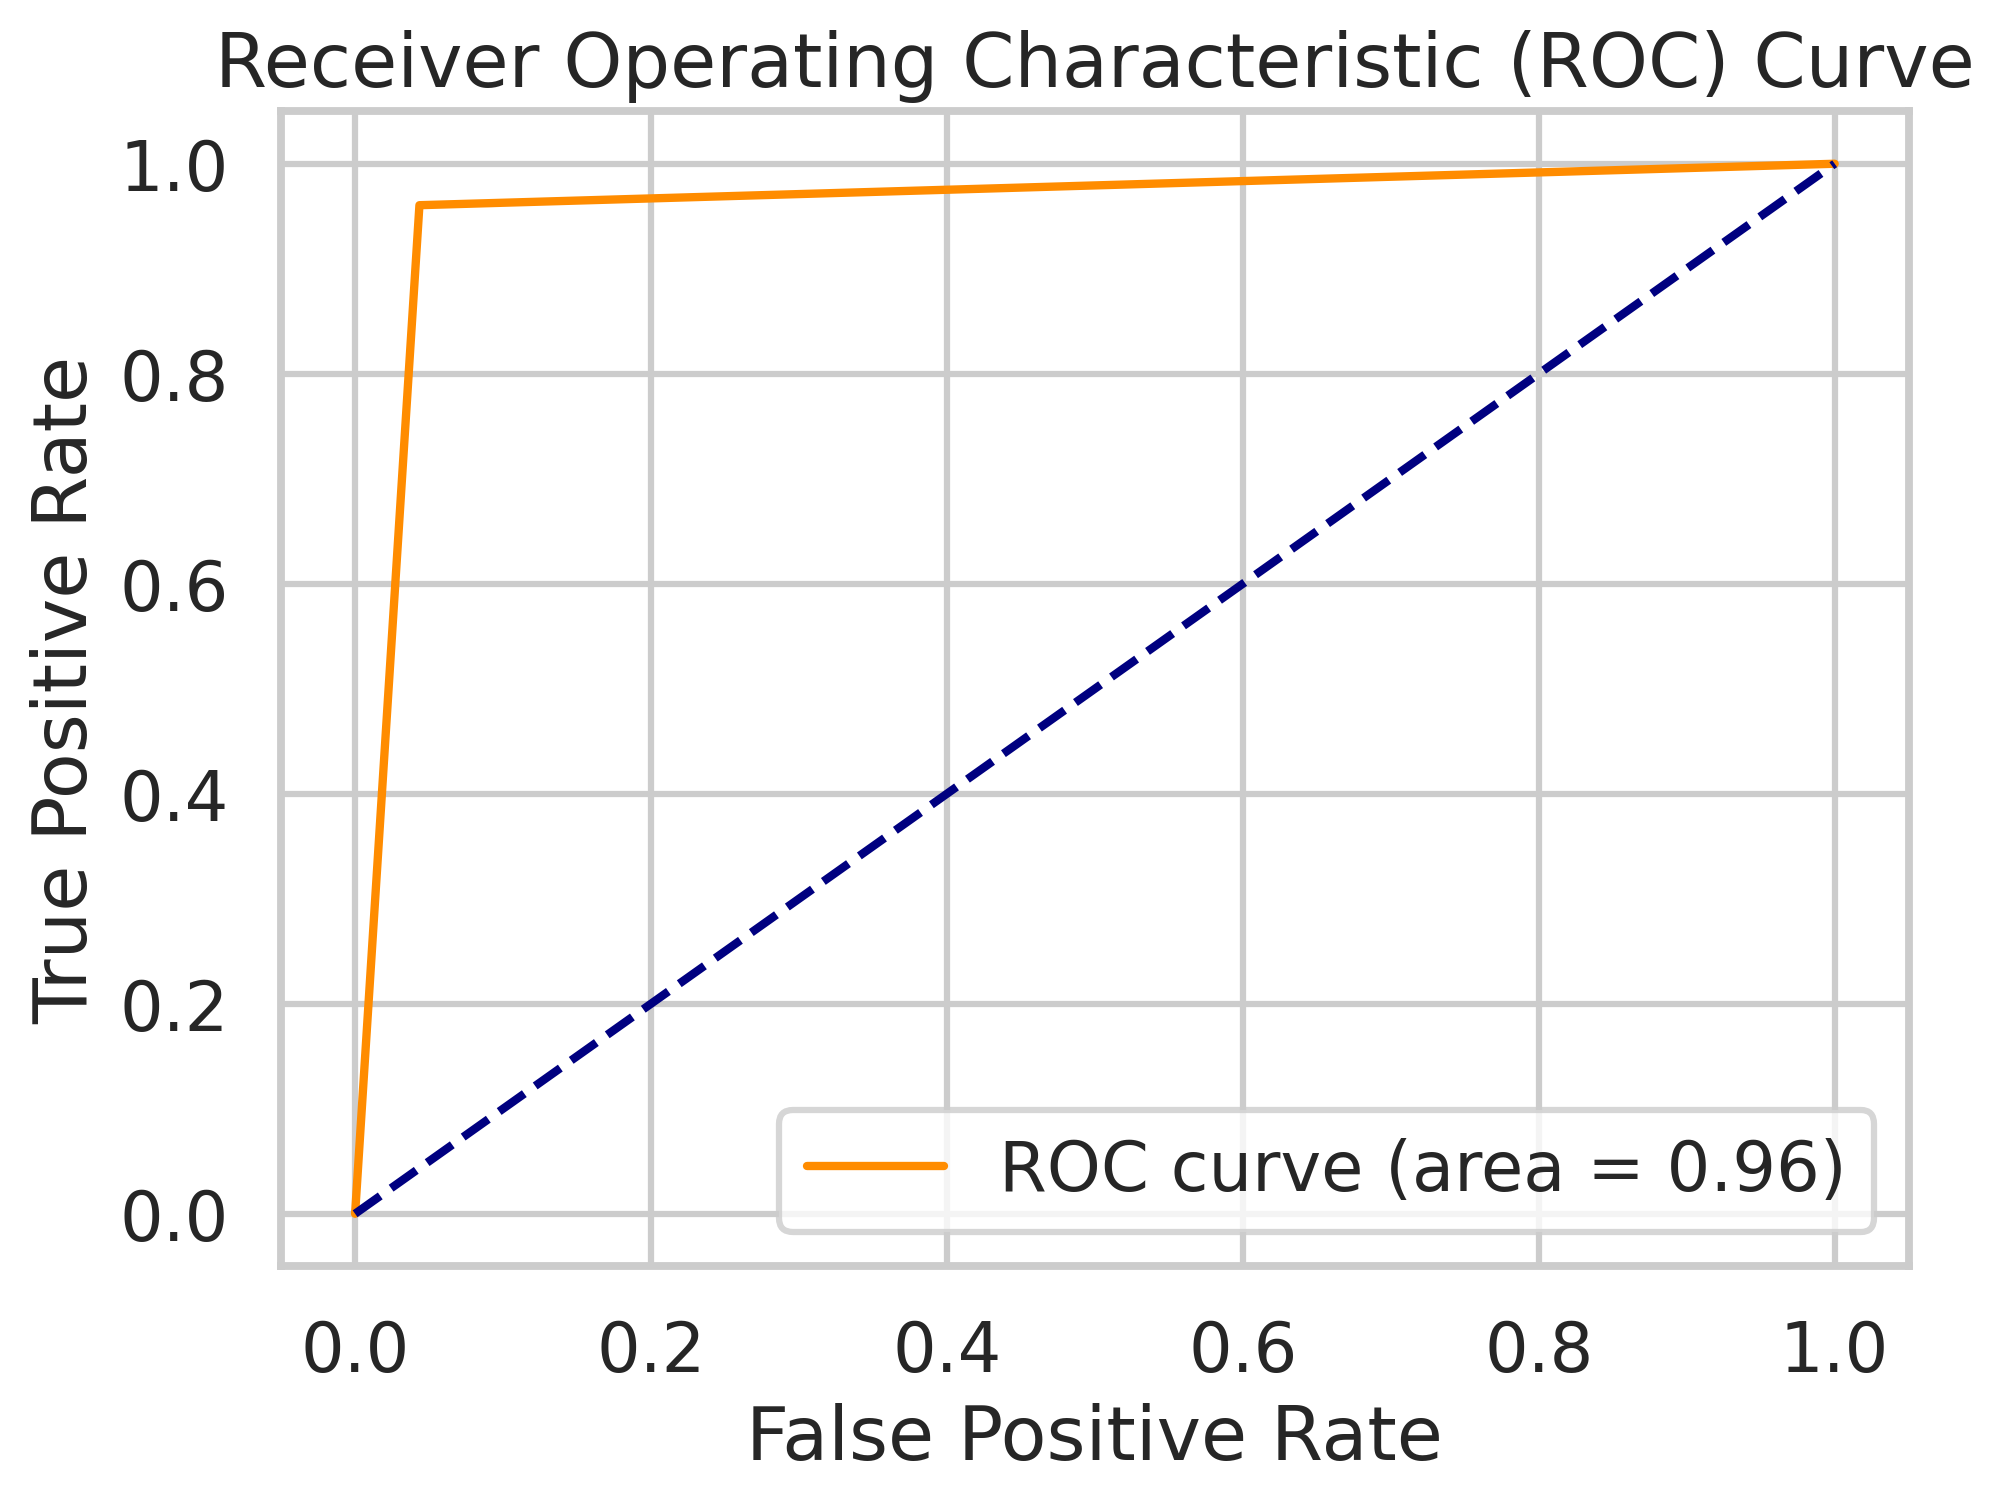

           Metric      Value
0   True Positive  73.000000
1   True Negative  22.000000
2  False Positive   1.000000
3  False Negative   3.000000
4     Sensitivity   0.960526
5     Specificity   0.956522


In [52]:
# Calculate sensitivity and specificity
TN, FP, FN, TP = cm.ravel()  # True Negative, False Positive, False Negative, True Positive

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(WHO_validation_df['cvd_risk_cat_g'], WHO_validation_df['w'])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Additional metrics: Display confusion matrix as a table
metrics_table = {
    'Metric': ['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Sensitivity', 'Specificity'],
    'Value': [TP, TN, FP, FN, sensitivity, specificity]
}

metrics_df = pd.DataFrame(metrics_table)
print(metrics_df)


#SSL

"""
Self-Training pipeline template
- Tune RF, XGB, MLP, SVC (GridSearchCV)
- Train baseline models (using best params)
- Calibrate with isotonic regression (fallback to sigmoid if needed)
- Self-train by pseudo-labeling unlabeled data with confidence >= 0.99,
  iterating up to 15 times or until no unlabeled samples remain
- Evaluate and produce comparison tables + plots
"""

In [53]:
# --------------------------
# Utility functions
# --------------------------

def ensure_array(X):
    """Return numpy array for stacking/removal ops (works for pandas DataFrame too)."""
    if hasattr(X, "values"):
        return X.values
    return np.asarray(X)

def compute_metrics(y_true, y_pred, y_proba=None, labels=None):
    """
    Compute a set of classification metrics in a dict.
    For multiclass AUC, we attempt a macro OVR calculation if probabilities provided.
    """
    out = {}
    out['accuracy'] = accuracy_score(y_true, y_pred)
    out['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    out['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    out['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    out['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    out['classification_report'] = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # ROC-AUC (multiclass handled via label_binarize + ovR)
    if (y_proba is not None) and (y_proba.ndim == 2):
        try:
            classes = labels if labels is not None else np.unique(np.concatenate([y_true, np.argmax(y_proba, axis=1)]))
            y_true_bin = label_binarize(y_true, classes=classes)
            # if binary, and label_binarize returns shape (n_samples,1) handle accordingly
            if y_true_bin.shape[1] == 1:
                # binary case: y_proba[:,1] should exist if proba shape 2; else use single prob
                if y_proba.shape[1] == 2:
                    out['roc_auc'] = roc_auc_score(y_true_bin, y_proba[:,1])
                else:
                    out['roc_auc'] = np.nan
            else:
                out['roc_auc_macro_ovr'] = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
        except Exception:
            out['roc_auc_macro_ovr'] = np.nan
    return out

def plot_confusion_matrix(y_true, y_pred, labels=None, ax=None, title=None):
    """Plot confusion matrix as heatmap."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if title:
            plt.title(title)
        plt.tight_layout()
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        if title: ax.set_title(title)




In [ ]:
# --------------------------
# Hyperparameter tuning (returns best estimators)
# --------------------------

def tune_classifiers(X_train, y_train, cv=5, n_jobs=-1, verbose=1):
    """
    Perform GridSearchCV for the four classifiers and return best estimators + scores.
    Accepts X_train (array/DF) and y_train (array/Series).
    """
    results = {}

    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf_params = {'n_estimators':[100,200,300], 'max_depth':[None,10,20], 'min_samples_split':[2,5]}
    rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring='f1_weighted', n_jobs=n_jobs, verbose=verbose)
    rf_grid.fit(X_train, y_train)
    results['RF'] = {'best_estimator': rf_grid.best_estimator_, 'best_score': rf_grid.best_score_, 'grid': rf_grid}

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_params = {'n_estimators':[100,200,300], 'learning_rate':[0.05,0.1,0.2], 'max_depth':[3,5]}
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=cv, scoring='f1_weighted', n_jobs=n_jobs, verbose=verbose)
    xgb_grid.fit(X_train, y_train)
    results['XGB'] = {'best_estimator': xgb_grid.best_estimator_, 'best_score': xgb_grid.best_score_, 'grid': xgb_grid}

    # MLP
    mlp = MLPClassifier(max_iter=500, random_state=42)
    mlp_params = {'hidden_layer_sizes':[(50,), (100,), (50,50)], 'alpha':[0.0001, 0.001]}
    mlp_grid = GridSearchCV(mlp, mlp_params, cv=cv, scoring='f1_weighted', n_jobs=n_jobs, verbose=verbose)
    mlp_grid.fit(X_train, y_train)
    results['MLP'] = {'best_estimator': mlp_grid.best_estimator_, 'best_score': mlp_grid.best_score_, 'grid': mlp_grid}

    # SVC (note: SVC must have probability=True for later calibration/proba)
    svc = SVC(probability=True, random_state=42)
    svc_params = {'C':[0.1,1,10], 'kernel':['rbf','linear']}
    svc_grid = GridSearchCV(svc, svc_params, cv=cv, scoring='f1_weighted', n_jobs=n_jobs, verbose=verbose)
    svc_grid.fit(X_train, y_train)
    results['SVC'] = {'best_estimator': svc_grid.best_estimator_, 'best_score': svc_grid.best_score_, 'grid': svc_grid}

    return results

In [ ]:
# --------------------------
# Train baseline models and evaluate
# --------------------------

def train_and_evaluate_baselines(best_estimators, X_train, y_train, X_test, y_test, labels=None):
    """
    Train each best_estimator on X_train and evaluate on X_test.
    Returns dict with trained models and metrics.
    """
    baselines = {}
    for name, info in best_estimators.items():
        est = deepcopy(info['best_estimator'])
        est.fit(X_train, y_train)
        # Try to get probabilities if available
        y_pred = est.predict(X_test)
        y_proba = None
        if hasattr(est, "predict_proba"):
            try:
                y_proba = est.predict_proba(X_test)
            except Exception:
                y_proba = None
        metrics = compute_metrics(y_test, y_pred, y_proba, labels=labels)
        baselines[name] = {'estimator': est, 'metrics': metrics, 'y_pred': y_pred, 'y_proba': y_proba}
    return baselines



In [ ]:
# --------------------------
# Calibration helper (isotonic fallback to sigmoid)
# --------------------------

def calibrate_estimator(estimator, X_cal, y_cal, method='isotonic', cv=3):
    """
    Calibrate classifier probabilities using CalibratedClassifierCV.
    If isotonic fails (e.g., too few samples), fallback to sigmoid.
    Returns a fitted calibrated classifier (scikit-learn wrapper).
    """
    try:
        calib = CalibratedClassifierCV(base_estimator=deepcopy(estimator), method=method, cv=cv)
        calib.fit(X_cal, y_cal)
        return calib
    except Exception as e:
        # Fallback to sigmoid
        try:
            calib = CalibratedClassifierCV(base_estimator=deepcopy(estimator), method='sigmoid', cv=cv)
            calib.fit(X_cal, y_cal)
            return calib
        except Exception as e2:
            # If calibration fails, return original estimator (un-calibrated)
            print("Warning: calibration failed (isotonic/sigmoid). Using uncalibrated estimator.")
            return estimator

In [ ]:
# --------------------------
# Self-training loop (custom)
# --------------------------

def self_training_loop(base_estimator, X_labeled, y_labeled, X_unlabeled,
                       X_test=None, y_test=None, labels=None,
                       threshold=0.99, max_iter=15, calibrate=True, cv_calib=3,
                       cap_per_class=None, verbose=True):
    """
    Custom self-training:
    - Trains base_estimator on X_labeled
    - Calibrates it (isotonic or sigmoid fallback) if calibrate=True
    - Predicts probabilities on X_unlabeled, picks samples with max_prob >= threshold
      (optionally capping per class)
    - Adds those pseudo-labeled samples to labeled set, removes from unlabeled set
    - Retrains and repeats up to max_iter or until no unlabeled samples meet threshold
    Returns final model (last calibrated estimator), and history list with per-iteration records.
    History record example:
      {'iter':1, 'n_added': 23, 'metrics': {...}, 'cumulative_added': 23}
    """
    # Ensure arrays for stacking/removing
    X_l = ensure_array(X_labeled)
    y_l = np.asarray(y_labeled)
    X_u = ensure_array(X_unlabeled)

    history = []
    cumulative_added = 0

    for it in range(1, max_iter+1):
        if verbose:
            print(f"Self-train iteration {it} — labeled: {len(y_l)}, unlabeled remaining: {len(X_u)}")

        # Fit base estimator on current labeled set
        model = deepcopy(base_estimator)
        model.fit(X_l, y_l)

        # Calibrate probabilities (if requested)
        if calibrate:
            calibrated = calibrate_estimator(model, X_l, y_l, method='isotonic', cv=cv_calib)
        else:
            calibrated = model

        # If no unlabeled left → stop
        if X_u.shape[0] == 0:
            if verbose: print("No unlabeled samples remain. Stopping.")
            break

        # Get predicted probabilities on unlabeled
        if not hasattr(calibrated, "predict_proba"):
            # Cannot pseudo-label without probability estimates
            if verbose: print("Model has no predict_proba. Stopping self-training.")
            break

        probs = calibrated.predict_proba(X_u)
        max_probs = probs.max(axis=1)
        candidate_idx = np.where(max_probs >= threshold)[0]

        # If none meet threshold → stop
        if candidate_idx.size == 0:
            if verbose: print("No candidates exceed threshold. Stopping.")
            break

        # Optionally cap number added per class to avoid imbalance explosion
        if cap_per_class is not None:
            kept = []
            classes = np.argmax(probs[candidate_idx], axis=1)
            for cls in np.unique(classes):
                cls_idx = candidate_idx[classes == cls]
                if len(cls_idx) > cap_per_class:
                    # choose top-k by prob
                    cls_probs = probs[cls_idx, cls]
                    top_k_idx = cls_idx[np.argsort(cls_probs)[-cap_per_class:]]
                    kept.extend(top_k_idx.tolist())
                else:
                    kept.extend(cls_idx.tolist())
            candidate_idx = np.array(sorted(kept), dtype=int)

        # Assign pseudo-labels
        pseudo_labels = np.argmax(probs[candidate_idx], axis=1)
        X_new = X_u[candidate_idx]
        y_new = pseudo_labels

        # Append to labeled
        X_l = np.vstack([X_l, X_new])
        y_l = np.concatenate([y_l, y_new])
        n_added = len(candidate_idx)
        cumulative_added += n_added

        # Remove from unlabeled
        mask = np.ones(X_u.shape[0], dtype=bool)
        mask[candidate_idx] = False
        X_u = X_u[mask]

        # Evaluate on test set if provided
        metrics = None
        if (X_test is not None) and (y_test is not None):
            y_pred_test = calibrated.predict(X_test)
            y_proba_test = calibrated.predict_proba(X_test) if hasattr(calibrated, "predict_proba") else None
            metrics = compute_metrics(y_test, y_pred_test, y_proba_test, labels=labels)

        history.append({
            'iter': it,
            'n_added': n_added,
            'cumulative_added': cumulative_added,
            'metrics': metrics
        })

        if verbose:
            print(f"  Added {n_added} pseudo-labeled samples (cumulative {cumulative_added}).")
            if metrics:
                print(f"  Test F1-weighted: {metrics.get('f1_weighted', np.nan):.4f}, Accuracy: {metrics.get('accuracy', np.nan):.4f}")

        # Stop early if unlabeled exhausted
        if X_u.shape[0] == 0:
            if verbose: print("All unlabeled samples were pseudo-labeled. Stopping.")
            break

    # Final model: retrain on all labeled and calibrate for final predictions
    final_model = deepcopy(base_estimator)
    final_model.fit(X_l, y_l)
    if calibrate:
        final_calib = calibrate_estimator(final_model, X_l, y_l, method='isotonic', cv=cv_calib)
        final_model = final_calib

    return final_model, history

In [ ]:
# --------------------------
# Visualization helpers
# --------------------------

def plot_iteration_history(history, metric_key='f1_weighted', ax=None, title=None): # Added ax and title parameters
    """
    Plot metric trajectory across iterations and number of added pseudo-labels per iteration.
    history: list of iter records from self_training_loop
    ax: matplotlib axis to plot on (optional)
    title: title for the plot (optional)
    """
    iterations = [h['iter'] for h in history]
    n_added = [h['n_added'] for h in history]
    # Safely access the metric, using .get()
    metric_vals = [h.get('metrics', {}).get(metric_key, np.nan) for h in history]

    if ax is None:
        fig, ax1 = plt.subplots(figsize=(8,5))
    else:
        ax1 = ax
        fig = ax.figure

    ax1.plot(iterations, metric_vals, marker='o', label=metric_key)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel(metric_key)
    ax1.set_xticks(iterations)
    ax1.grid(False)

    ax2 = ax1.twinx()
    ax2.bar(iterations, n_added, alpha=0.25, label='n_added', align='center')
    ax2.set_ylabel('Number of pseudo-labeled samples added')

    # Ensure legends are drawn correctly when using subplots
    if ax is None:
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

    if title:
        ax1.set_title(title)

    if ax is None:
        plt.tight_layout()
        plt.show()


def plot_baseline_vs_ssl(baseline_metrics, ssl_metrics, metric_key='f1_weighted'):
    """
    baseline_metrics / ssl_metrics: dict mapping model name -> metrics dict
    """
    models = list(baseline_metrics.keys())
    base_vals = [baseline_metrics[m]['metrics'][metric_key] for m in models]
    ssl_vals = [ssl_metrics[m]['metrics'][metric_key] for m in models]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, base_vals, width, label='Baseline')
    ax.bar(x + width/2, ssl_vals, width, label='Self-Training')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylabel(metric_key)
    ax.legend()
    plt.title(f'Baseline vs Self-Training ({metric_key})')
    plt.tight_layout()
    plt.show()

In [54]:
# data setup
df = sd_clean_cvd[['age', 'sex', 'current_smoker', 'DM',
                   'avg_systolic', 'Total Cholesterol', 'cvd_risk_cat_g']].copy()

# Separate labeled and unlabeled data
labeled_data = df.dropna(subset=['cvd_risk_cat_g']).copy()
unlabeled_data = df[df['cvd_risk_cat_g'].isna()].copy()

# Define features and target
features = ['age', 'sex', 'current_smoker', 'DM', 'avg_systolic', 'Total Cholesterol']
X_labeled = labeled_data[features]
y_labeled = labeled_data['cvd_risk_cat_g']
X_unlabeled = unlabeled_data[features]

# Label Encoding for the target variable 'cvd_risk_cat_g' if it's not numerical
le = LabelEncoder()
y_labeled_encoded = le.fit_transform(y_labeled)

# Split labeled data into training and test sets
# The test set will be held out for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled_encoded, test_size=0.2, random_state=42, stratify=y_labeled_encoded
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

imputer = SimpleImputer(strategy='median')
X_unlabeled_scaled = imputer.fit_transform(X_unlabeled_scaled)

In [55]:
# Hyperparameter tuning on labeled training set

tuned = tune_classifiers(X_train_scaled, y_train, cv=5, n_jobs=-1, verbose=1)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:35:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [56]:
#Train baseline models and evaluate on held-out test set
baselines = train_and_evaluate_baselines(tuned, X_train_scaled, y_train, X_test_scaled, y_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:36:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Self-training per model
ssl_results = {}
for model_name, info in tuned.items():
     print(f"\n--- Self-training with base: {model_name} ---")
     base_est = deepcopy(info['best_estimator'])
     # ensure SVC has probability=True (GridSearch above should have chosen it)
     final_model, history = self_training_loop(base_est,
                                               X_train_scaled, y_train,
                                               X_unlabeled_scaled,
                                               X_test=X_test_scaled, y_test=y_test,
                                               labels=np.unique(y_train),
                                               threshold=0.99, max_iter=15,
                                               calibrate=True, cv_calib=3,
                                               cap_per_class=None, verbose=True)
#     # Evaluate final_model on test set
     y_pred_final = final_model.predict(X_test_scaled)
     y_proba_final = final_model.predict_proba(X_test_scaled) if hasattr(final_model, 'predict_proba') else None
     ssl_metrics = compute_metrics(y_test, y_pred_final, y_proba_final, labels=np.unique(y_train))
     ssl_results[model_name] = {'model': final_model, 'history': history, 'metrics': ssl_metrics, 'y_pred': y_pred_final, 'y_proba': y_proba_final}

In [58]:
# Create comparison table and plots

comparison = pd.DataFrame([{
     'model': m,
     #'f1_baseline': baselines[m]['metrics']['f1_weighted'],
     'f1_ssl': ssl_results[m]['metrics']['f1_weighted'],
     #'accuracy_baseline': baselines[m]['metrics']['accuracy'],
     'accuracy_ssl': ssl_results[m]['metrics']['accuracy'],
     #'precision_baseline': baselines[m]['metrics']['precision_weighted'],
     'precision_ssl': ssl_results[m]['metrics']['precision_weighted'],
     #'recall_baseline': baselines[m]['metrics']['recall_weighted'],
     'recall_ssl': ssl_results[m]['metrics']['recall_weighted'],
     #'roc_auc_baseline': baselines[m]['metrics'].get('roc_auc_macro_ovr', np.nan), # Access conditionally
     #'roc_auc_ssl': ssl_results[m]['metrics'].get('roc_auc_macro_ovr', np.nan), # Access conditionally
 } for m in baselines.keys()])
print(comparison)

  model    f1_ssl  accuracy_ssl  precision_ssl  recall_ssl
0    RF  0.966869      0.966957       0.967081    0.966957
1   XGB  0.975578      0.975652       0.975900    0.975652
2   MLP  0.989542      0.989565       0.989744    0.989565
3   SVC  0.984293      0.984348       0.984747    0.984348


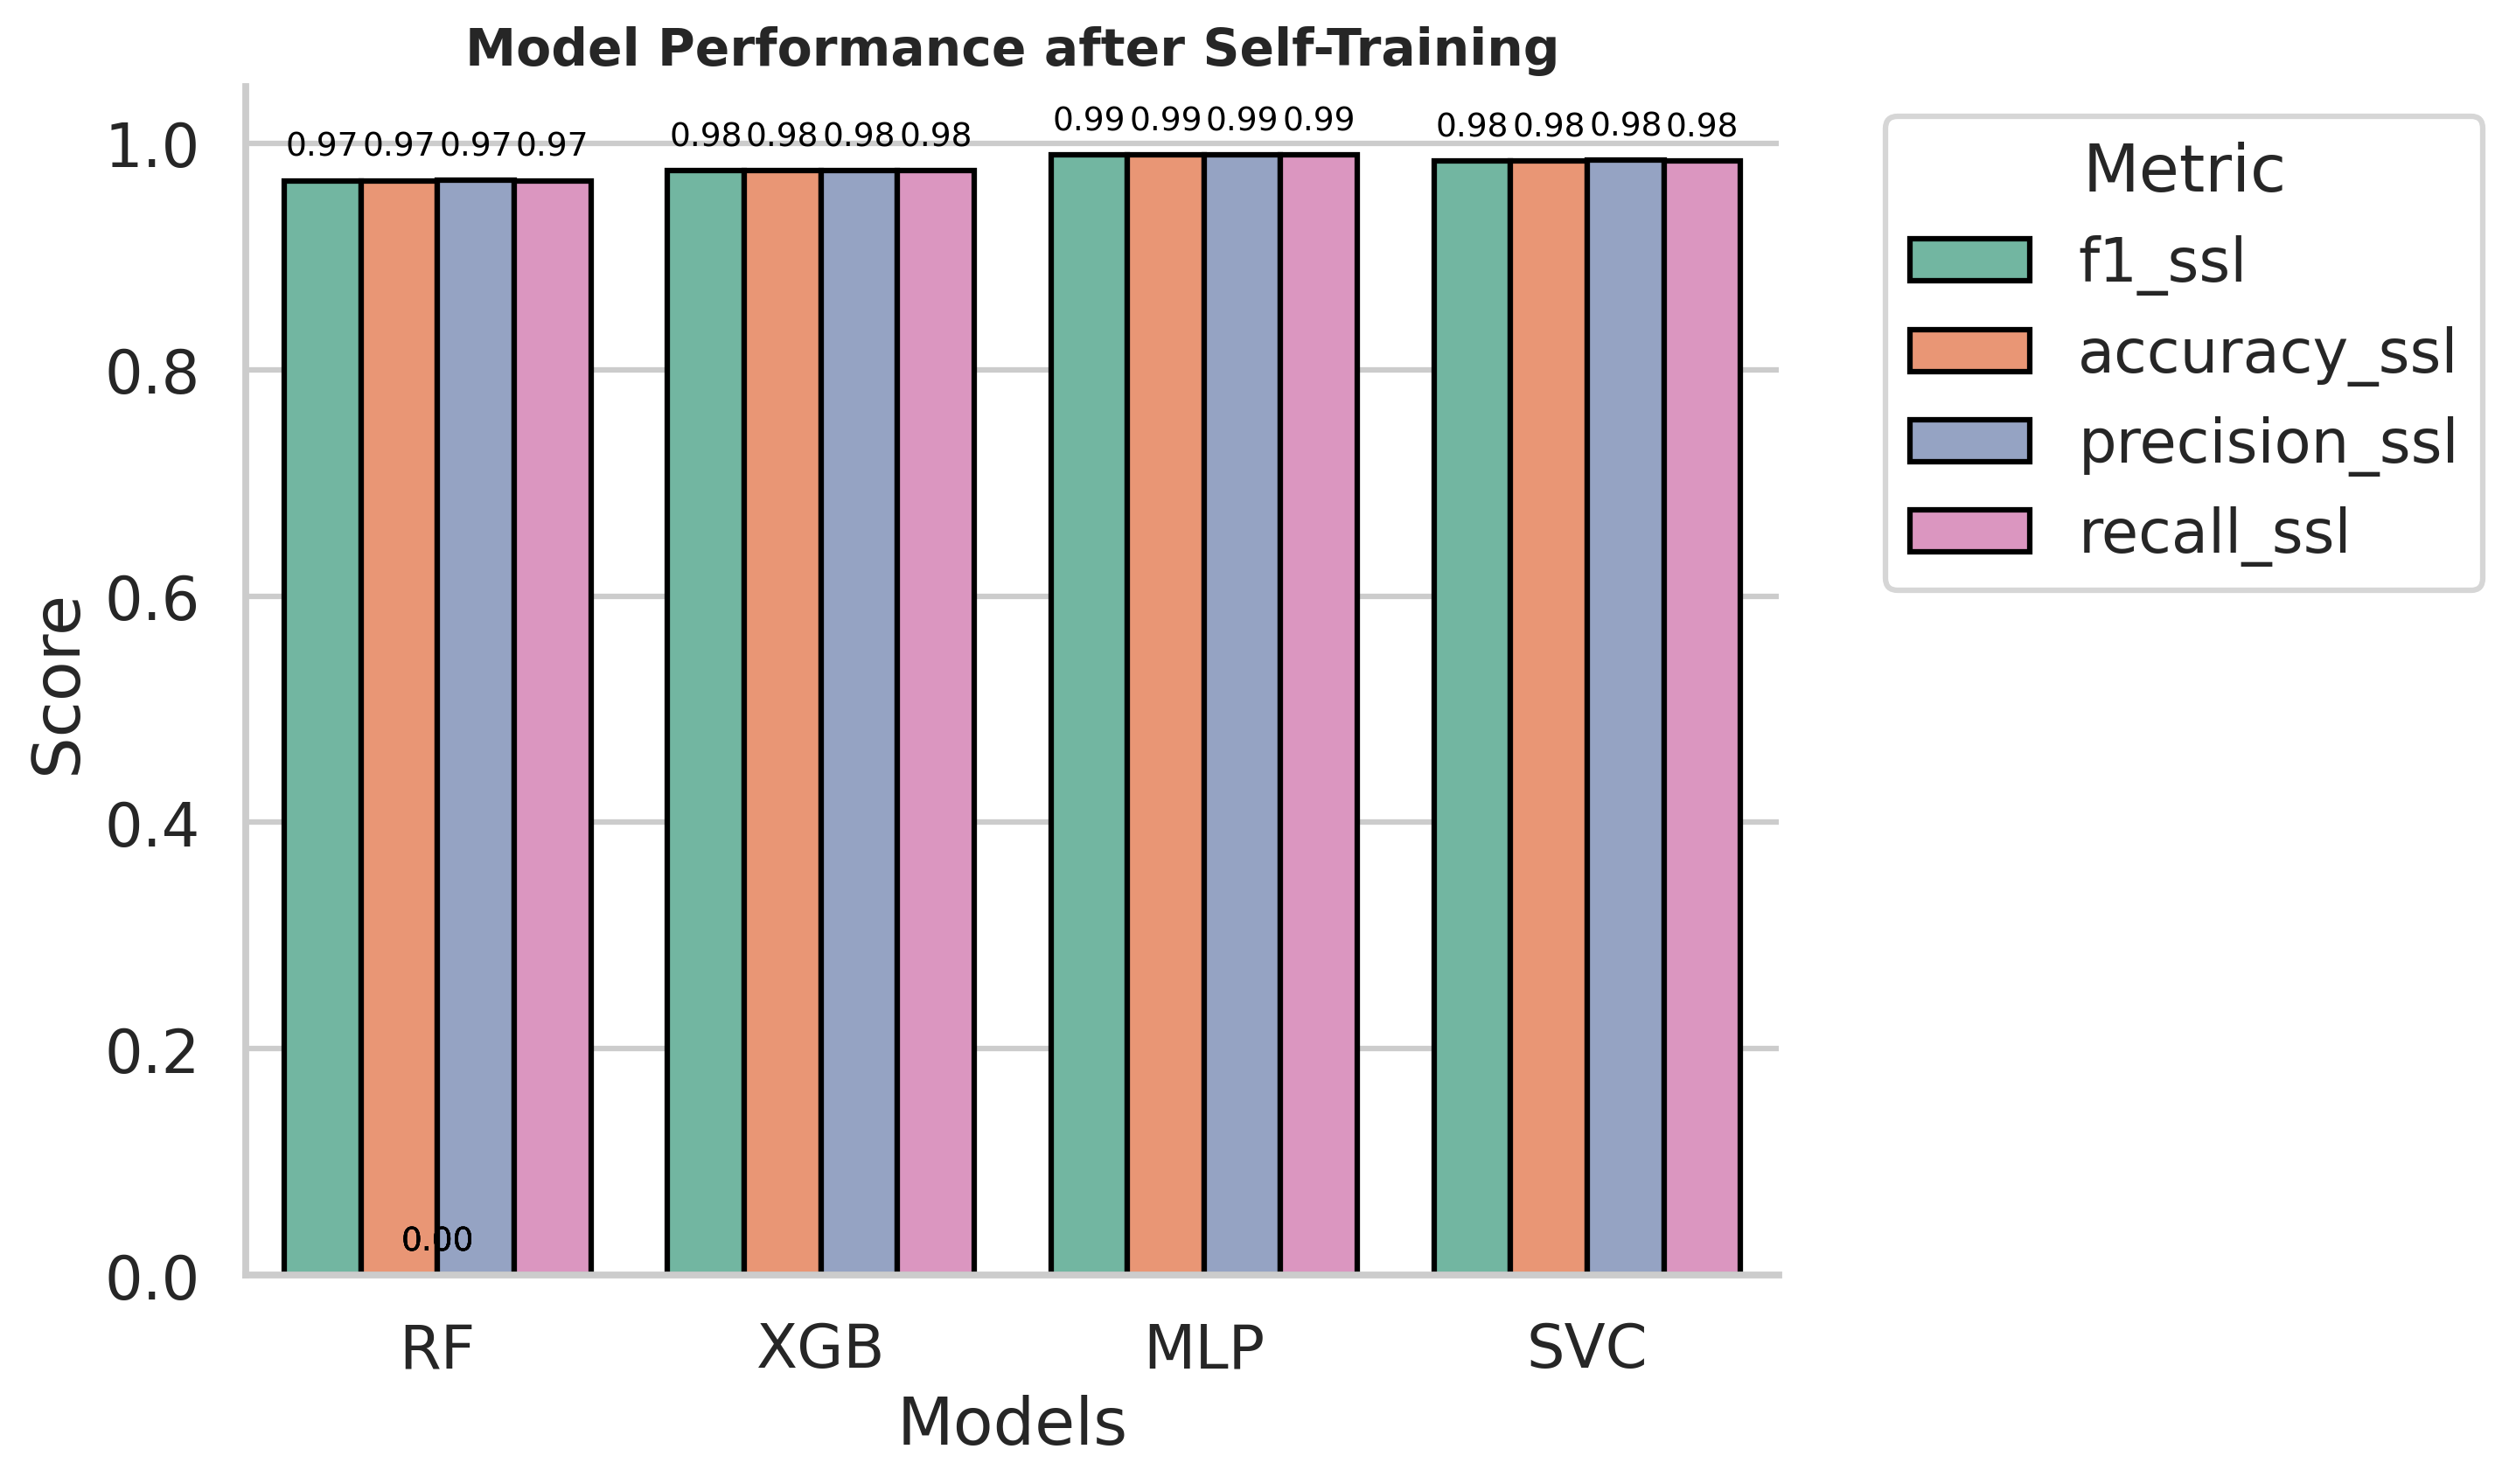

In [59]:

# Melt dataframe for long format (better for seaborn plotting)
comparison_melted = comparison.melt(
    id_vars='model',
    var_name='metric',
    value_name='score'
)

# Create a color palette
palette = sns.color_palette("Set2", n_colors=comparison_melted['metric'].nunique())

plt.figure(figsize=(10, 6))
sns.barplot(
    data=comparison_melted,
    x='model',
    y='score',
    hue='metric',
    palette=palette,
    edgecolor='black'
)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=9, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

# Formatting
plt.title("Model Performance after Self-Training", fontsize=14, weight='bold')
plt.ylabel("Score")
plt.xlabel("Models")
plt.ylim(0, 1.05)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

plt.tight_layout()
plt.show()


/tmp/ipython-input-1548607155.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


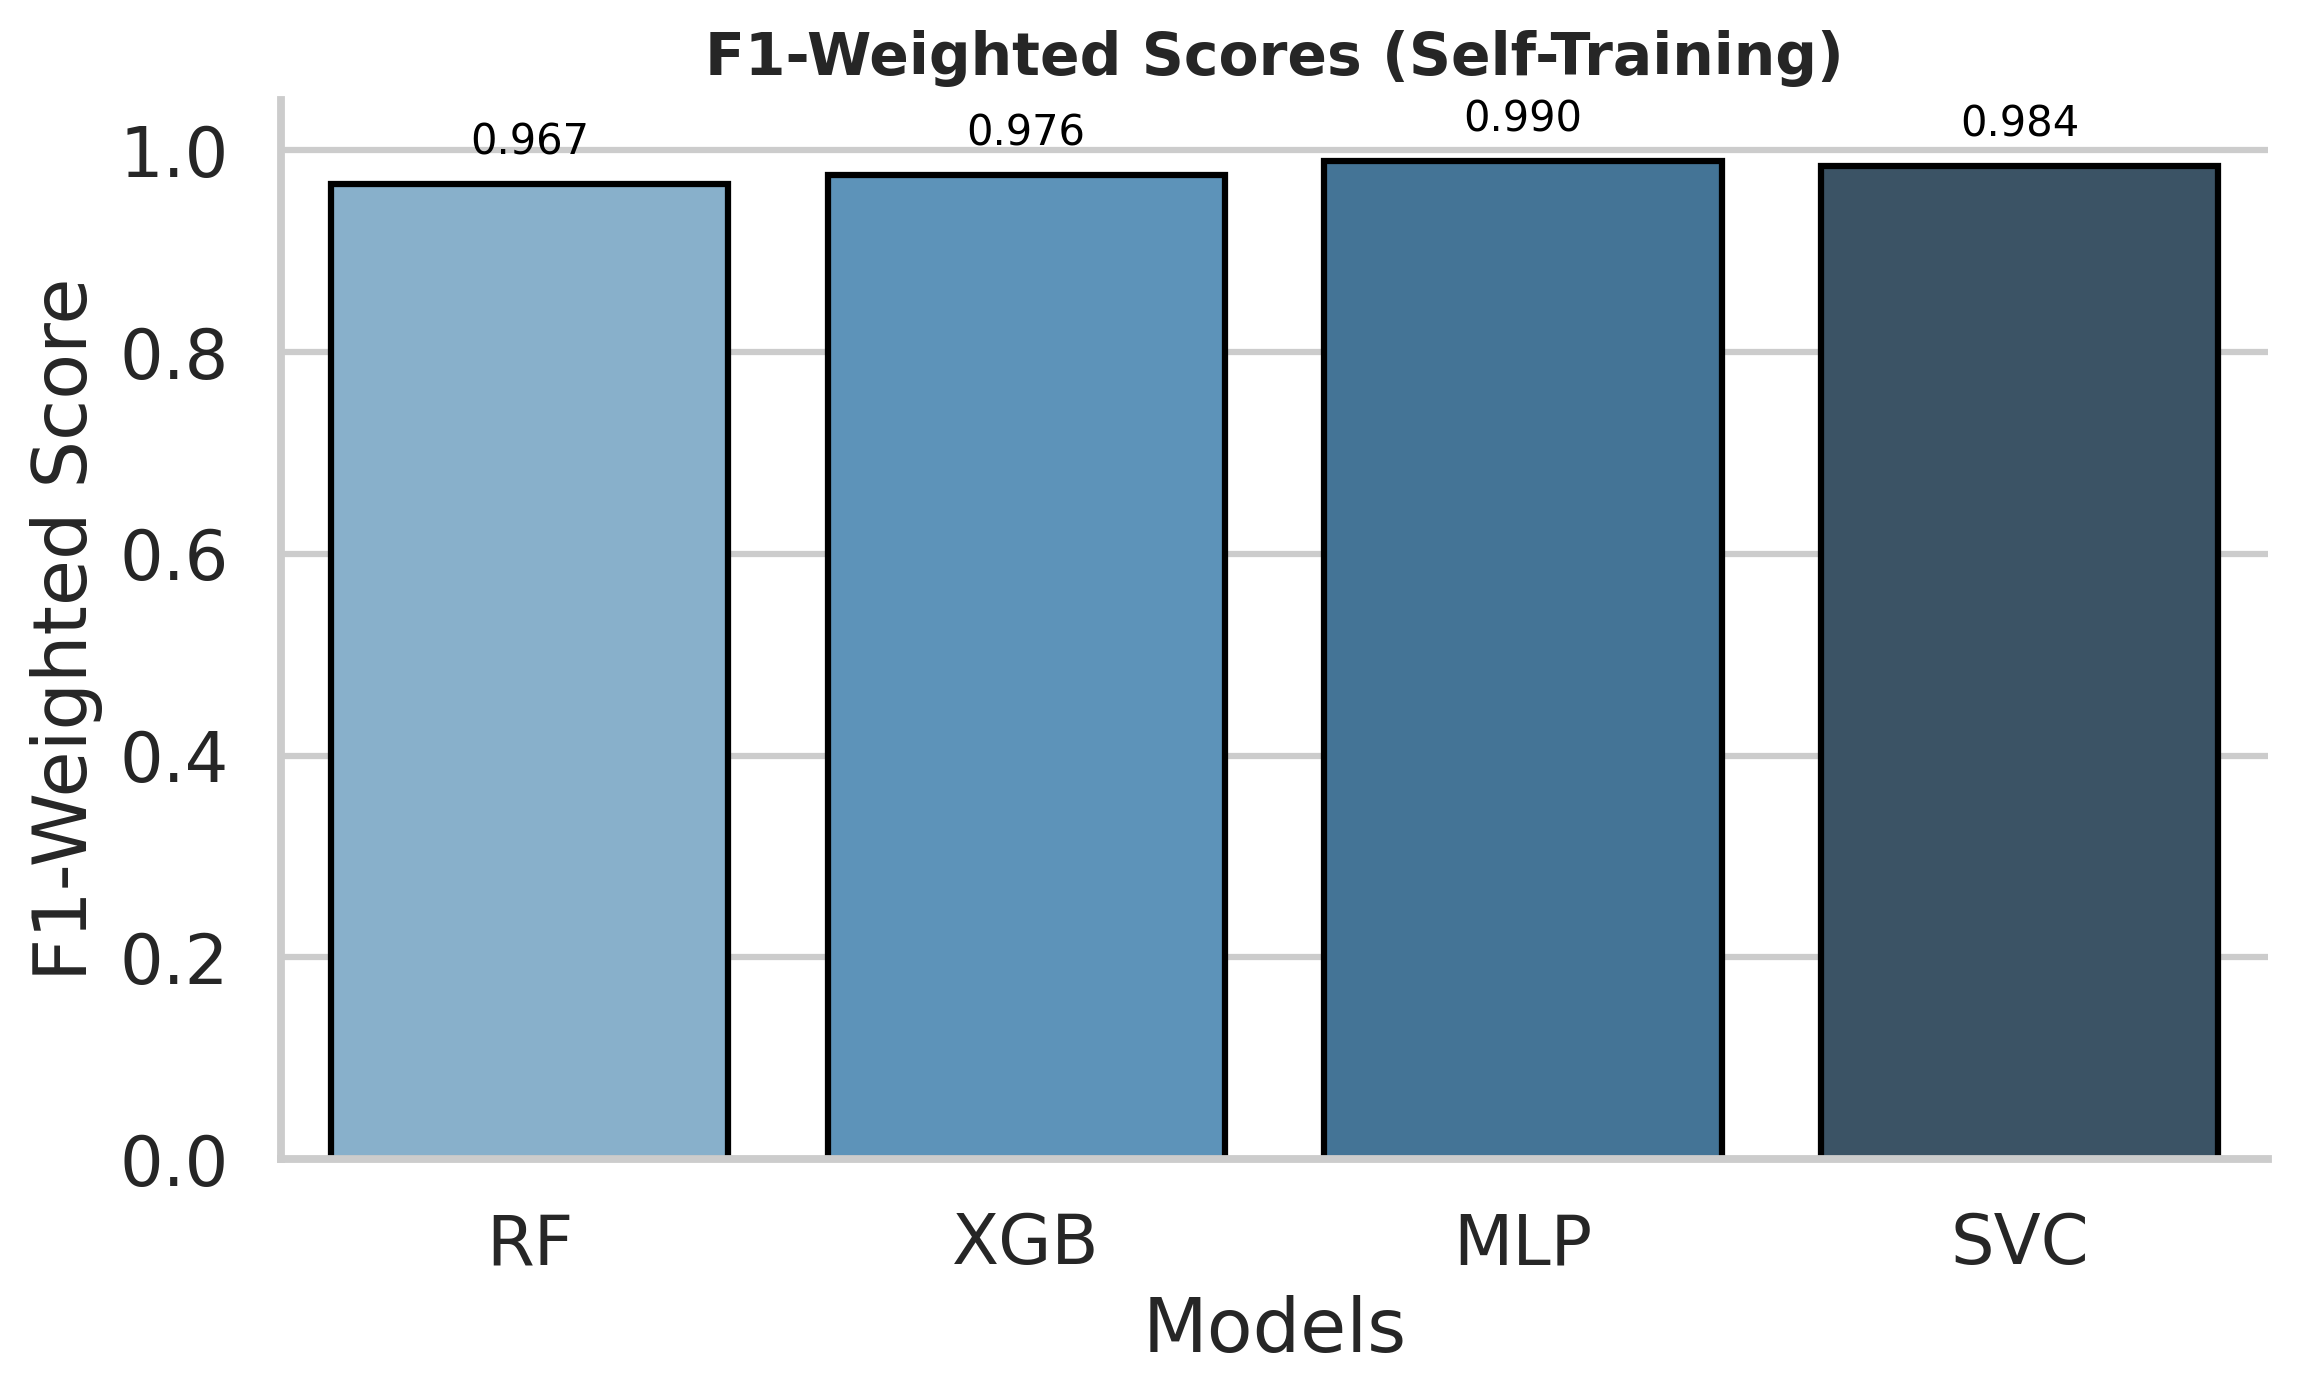

In [60]:

# Keep only model and f1_ssl
f1_df = comparison[['model', 'f1_ssl']]

plt.figure(figsize=(8, 5))
sns.barplot(
    data=f1_df,
    x='model',
    y='f1_ssl',
    palette="Blues_d",
    edgecolor='black'
)

# Add value labels on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

# Styling
plt.title("F1-Weighted Scores (Self-Training)", fontsize=14, weight='bold')
plt.ylabel("F1-Weighted Score")
plt.xlabel("Models")
plt.ylim(0, 1.05)
sns.despine()

plt.tight_layout()
plt.show()


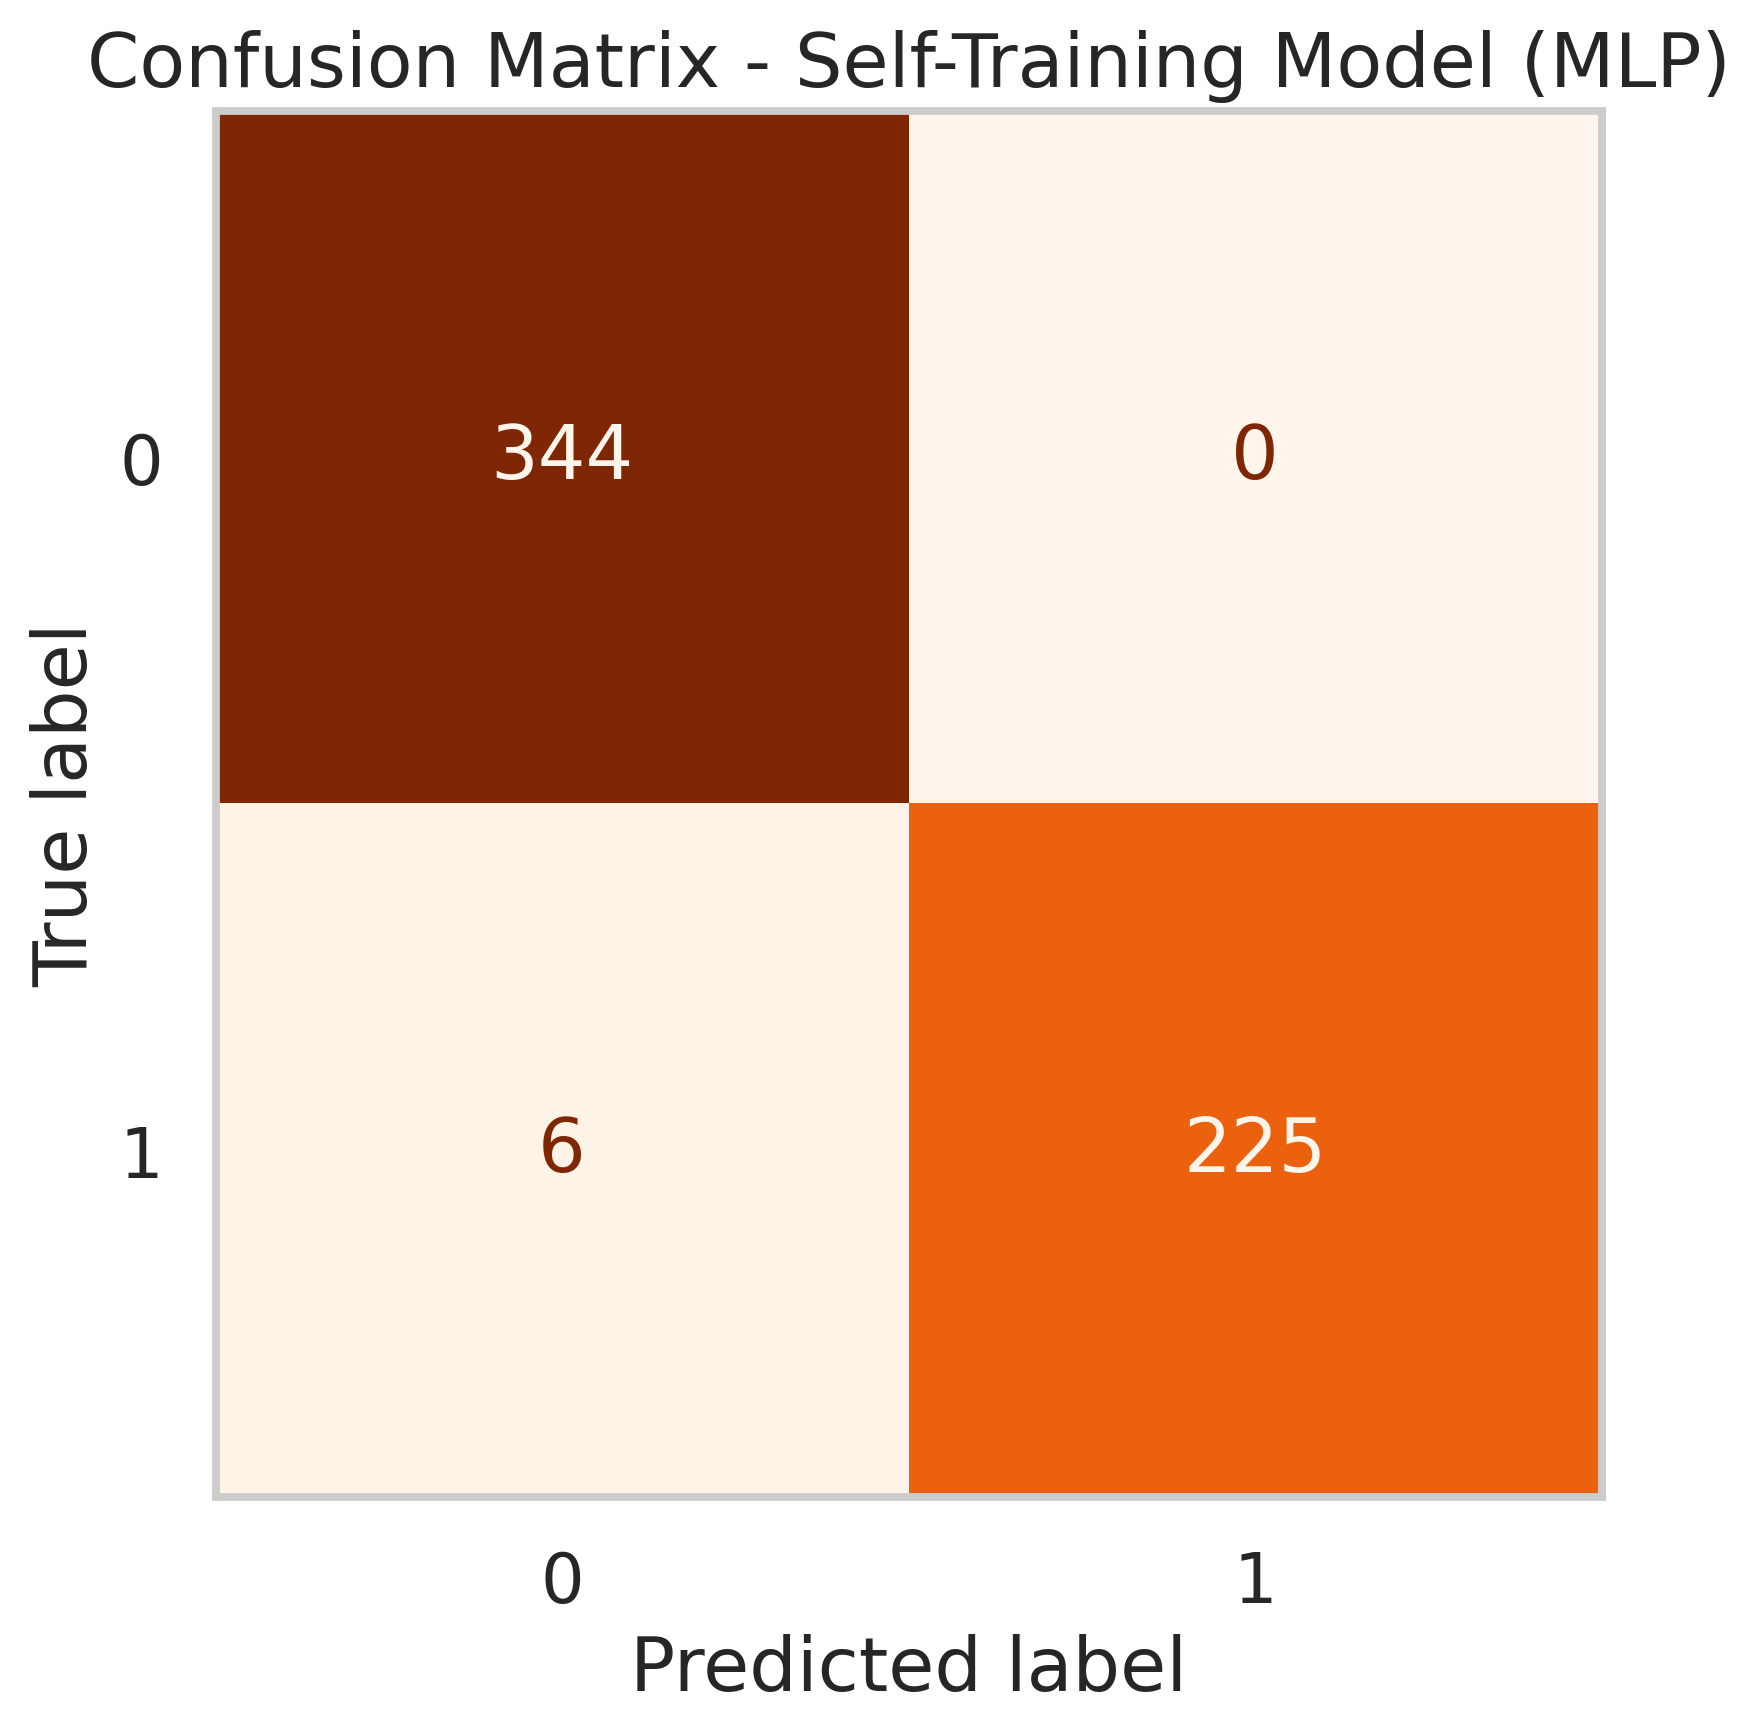

Classification Report - Self-Training Model (MLP)
              precision    recall  f1-score   support

           0      0.983     1.000     0.991       344
           1      1.000     0.974     0.987       231

    accuracy                          0.990       575
   macro avg      0.991     0.987     0.989       575
weighted avg      0.990     0.990     0.990       575



In [66]:
# Select the final self-trained model to evaluate
final_ssl_model = ssl_results['MLP']['model']

# Make predictions
y_pred = final_ssl_model.predict(X_test_scaled)  # Use the scaled test data

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Oranges", values_format='d', ax=ax, colorbar=False)  # change color
ax.set_title("Confusion Matrix - Self-Training Model (MLP)")
ax.grid(False)  # remove grid lines
plt.show()

# Classification Report
print("Classification Report - Self-Training Model (MLP)")
print(classification_report(y_test, y_pred, digits=3))


In [ ]:
# --------------------------
# Merge predicted labels back into sd_cvd_clean
# --------------------------

# Predict on the unlabeled data with the final self-trained MLP model
unlabeled_preds = final_ssl_model.predict(X_unlabeled_scaled)

# Convert encoded labels back to original categories
unlabeled_preds_decoded = le.inverse_transform(unlabeled_preds)

sd_cvd_clean = sd_clean_cvd.copy()

# Fill cvd_final
sd_cvd_clean['cvd_final'] = sd_cvd_clean['cvd_risk_cat_g'].copy()

# Update only the missing values (NaN) with MLP predictions
sd_cvd_clean.loc[sd_cvd_clean['cvd_risk_cat_g'].isna(), 'cvd_final'] = unlabeled_preds_decoded


/tmp/ipython-input-1089333353.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=sd_cvd_clean, x='cvd_final', palette="Set2", edgecolor='black')


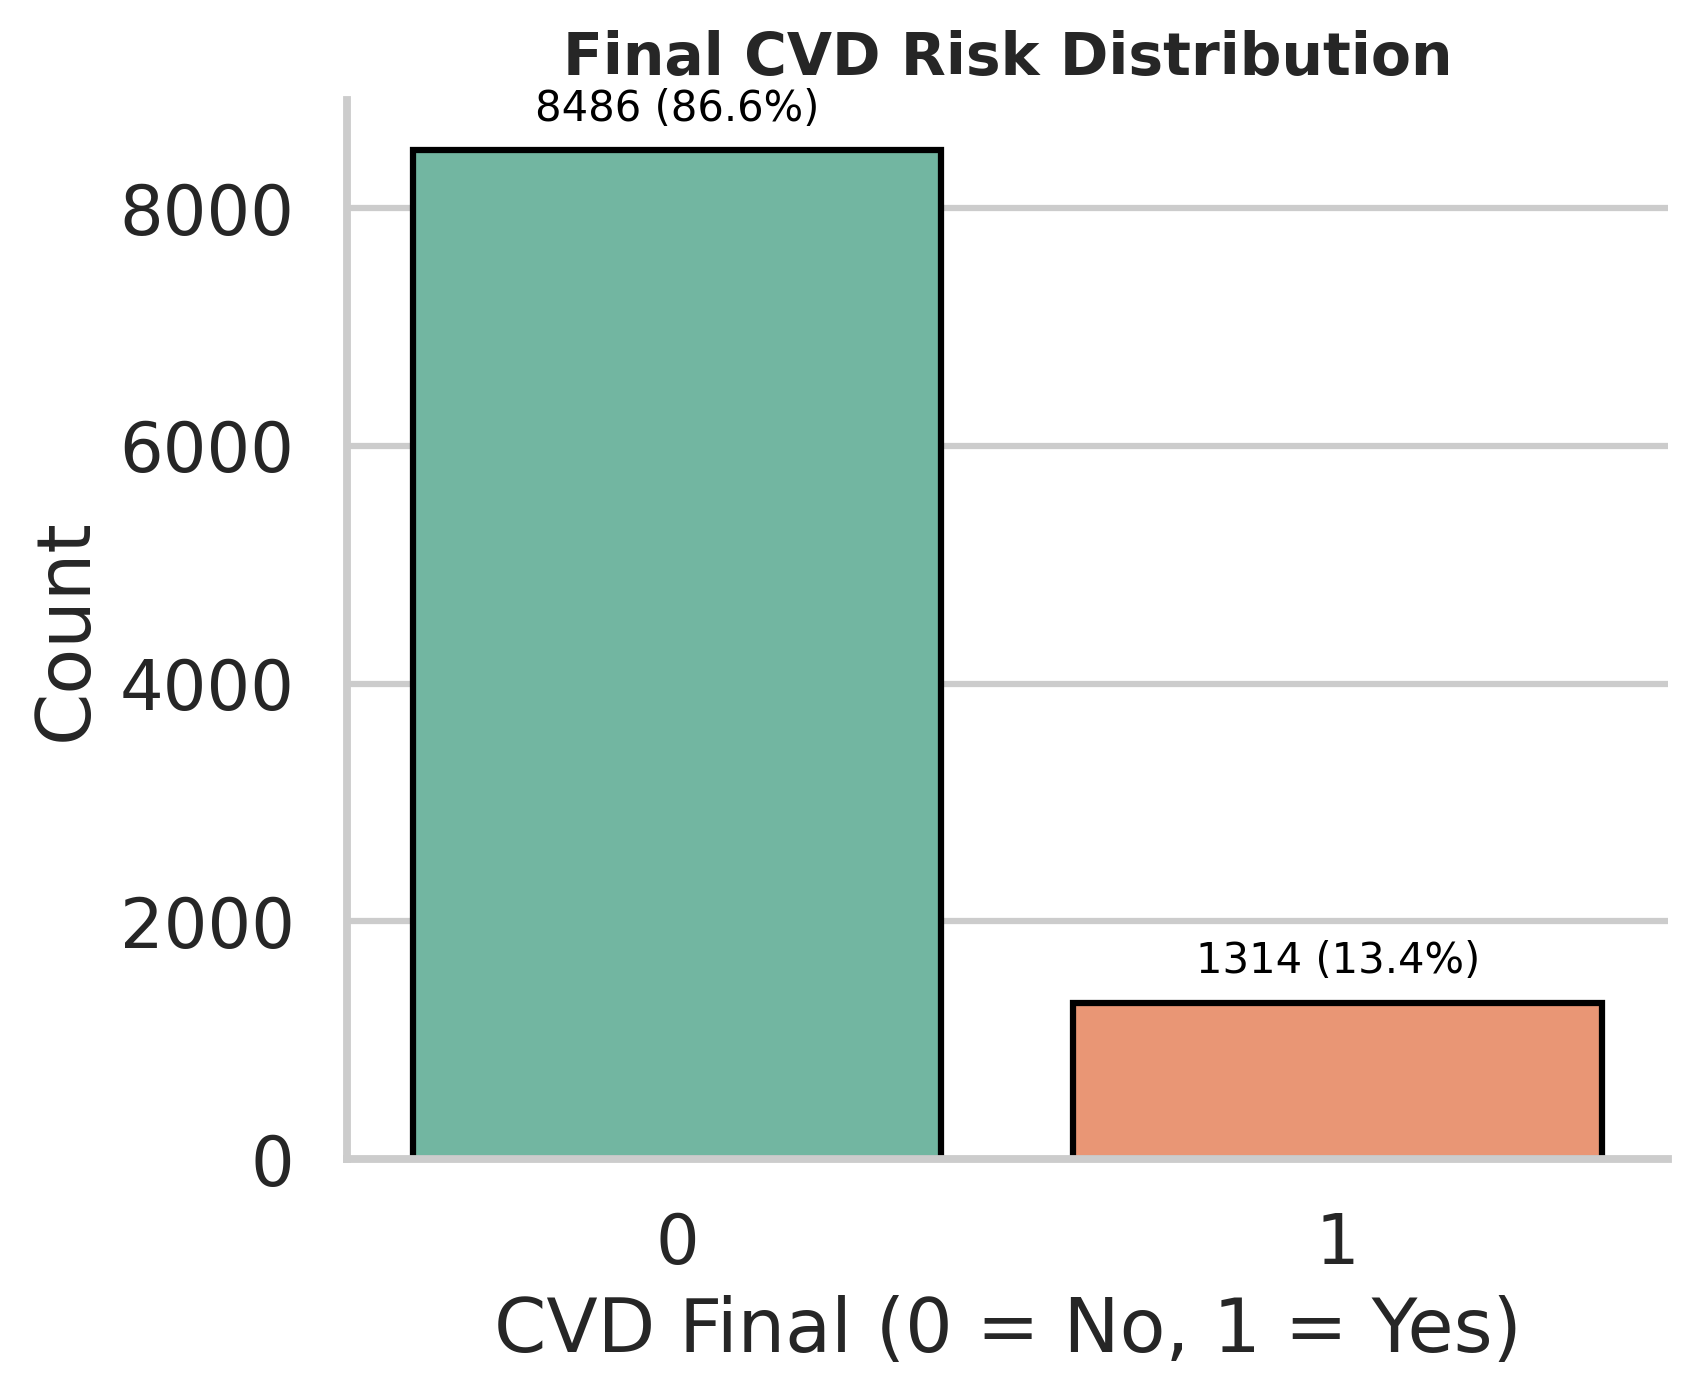

In [68]:
# Compute percentages
counts = sd_cvd_clean['cvd_final'].value_counts().sort_index()
percentages = counts / counts.sum() * 100

plt.figure(figsize=(6, 5))
ax = sns.countplot(data=sd_cvd_clean, x='cvd_final', palette="Set2", edgecolor='black')

# Add labels: count (percent%)
for i, p in enumerate(ax.patches):
    count = counts.iloc[i]
    percent = percentages.iloc[i]
    ax.annotate(
        f"{count} ({percent:.1f}%)",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

# Formatting
ax.set_title("Final CVD Risk Distribution", fontsize=14, weight='bold')
ax.set_xlabel("CVD Final (0 = No, 1 = Yes)")
ax.set_ylabel("Count")
sns.despine()

plt.tight_layout()
plt.show()


In [70]:
sd_cvd_new = sd_cvd_clean

/tmp/ipython-input-3755298466.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='cvd_final', data=sd_cvd_new, palette=colors)
/tmp/ipython-input-3755298466.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()])


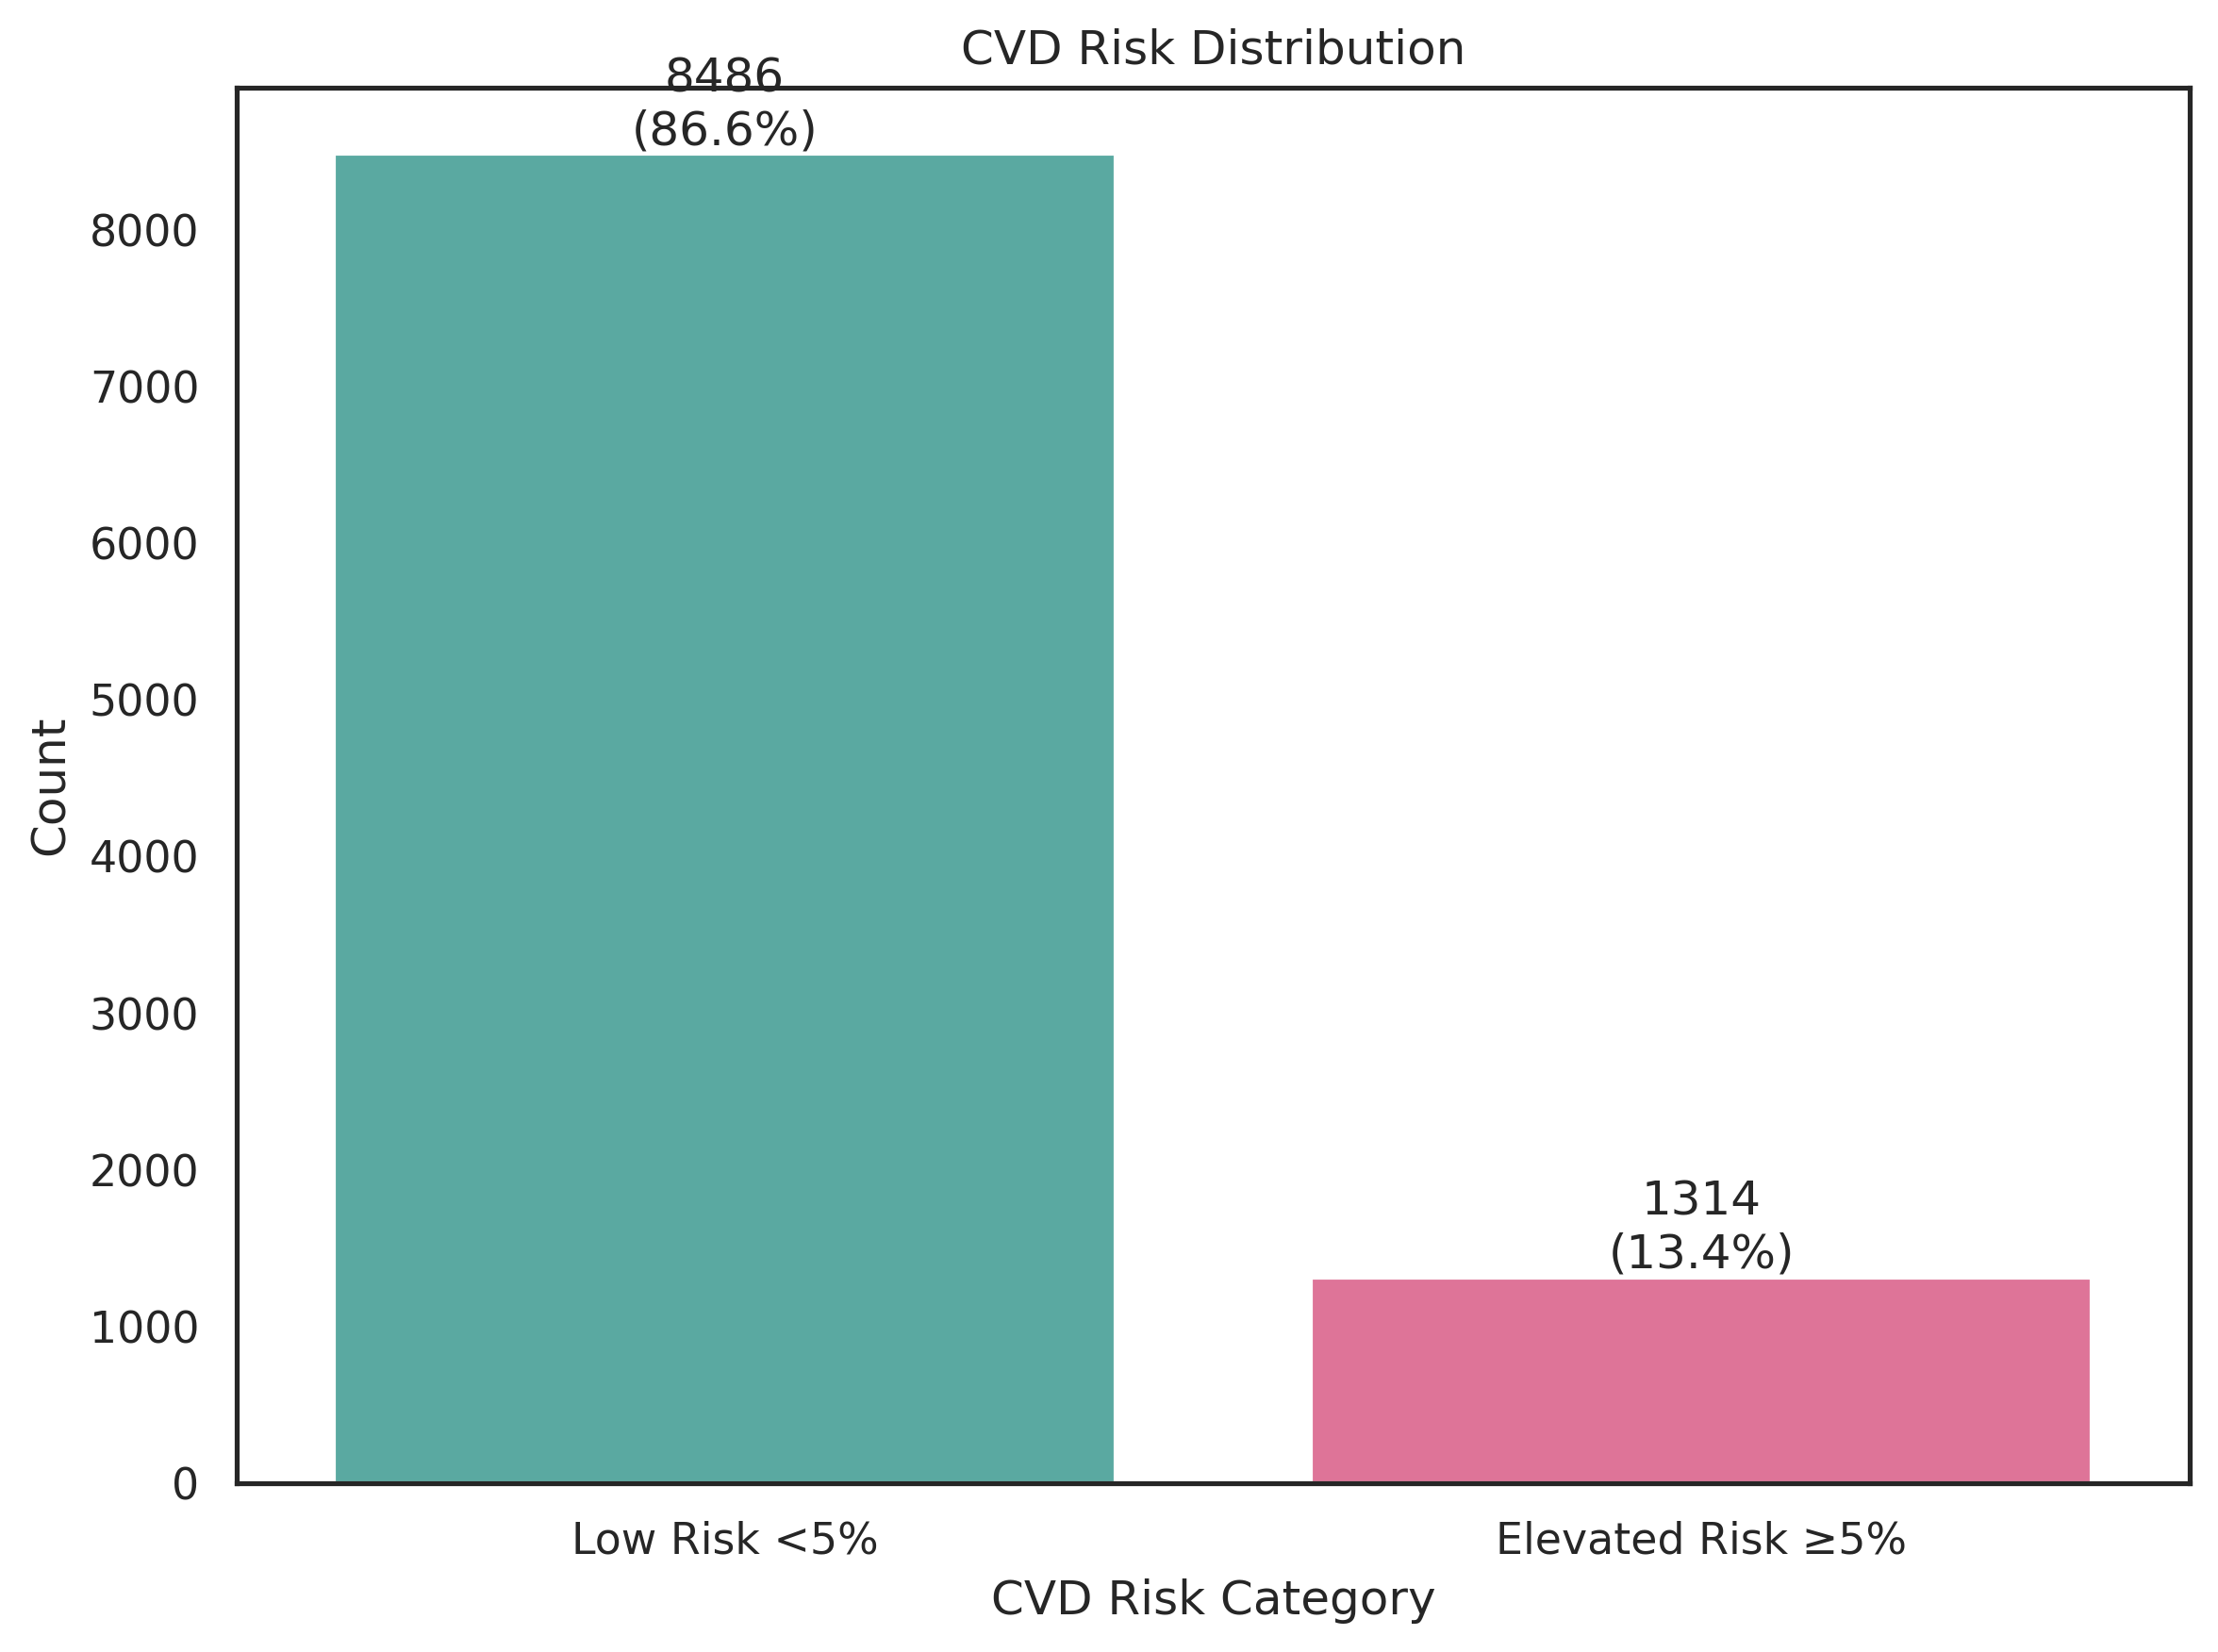

In [71]:
# Custom seaborn style
sns.set(style="white")

# Custom label and color map
label_map = {0: 'Low Risk <5%', 1: 'Elevated Risk ≥5%'}
colors = ['#4DB6AC', '#F06292']  # Teal and pink for a more distinct look

# === Full Dataset Bar Plot ===
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='cvd_final', data=sd_cvd_new, palette=colors)
plt.title('CVD Risk Distribution')
plt.xlabel('CVD Risk Category')
plt.ylabel('Count')

# Add count and percent labels
total = len(sd_cvd_new)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{count}\n({percent:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

# Custom x-tick labels
ax.set_xticklabels([label_map.get(int(label.get_text()), label.get_text()) for label in ax.get_xticklabels()])
plt.tight_layout()
plt.show()



/tmp/ipython-input-2828664225.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(x='cvd_final', data=young_data, palette=colors)
/tmp/ipython-input-2828664225.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label_map.get(int(label.get_text()), label.get_text()) for label in ax2.get_xticklabels()])


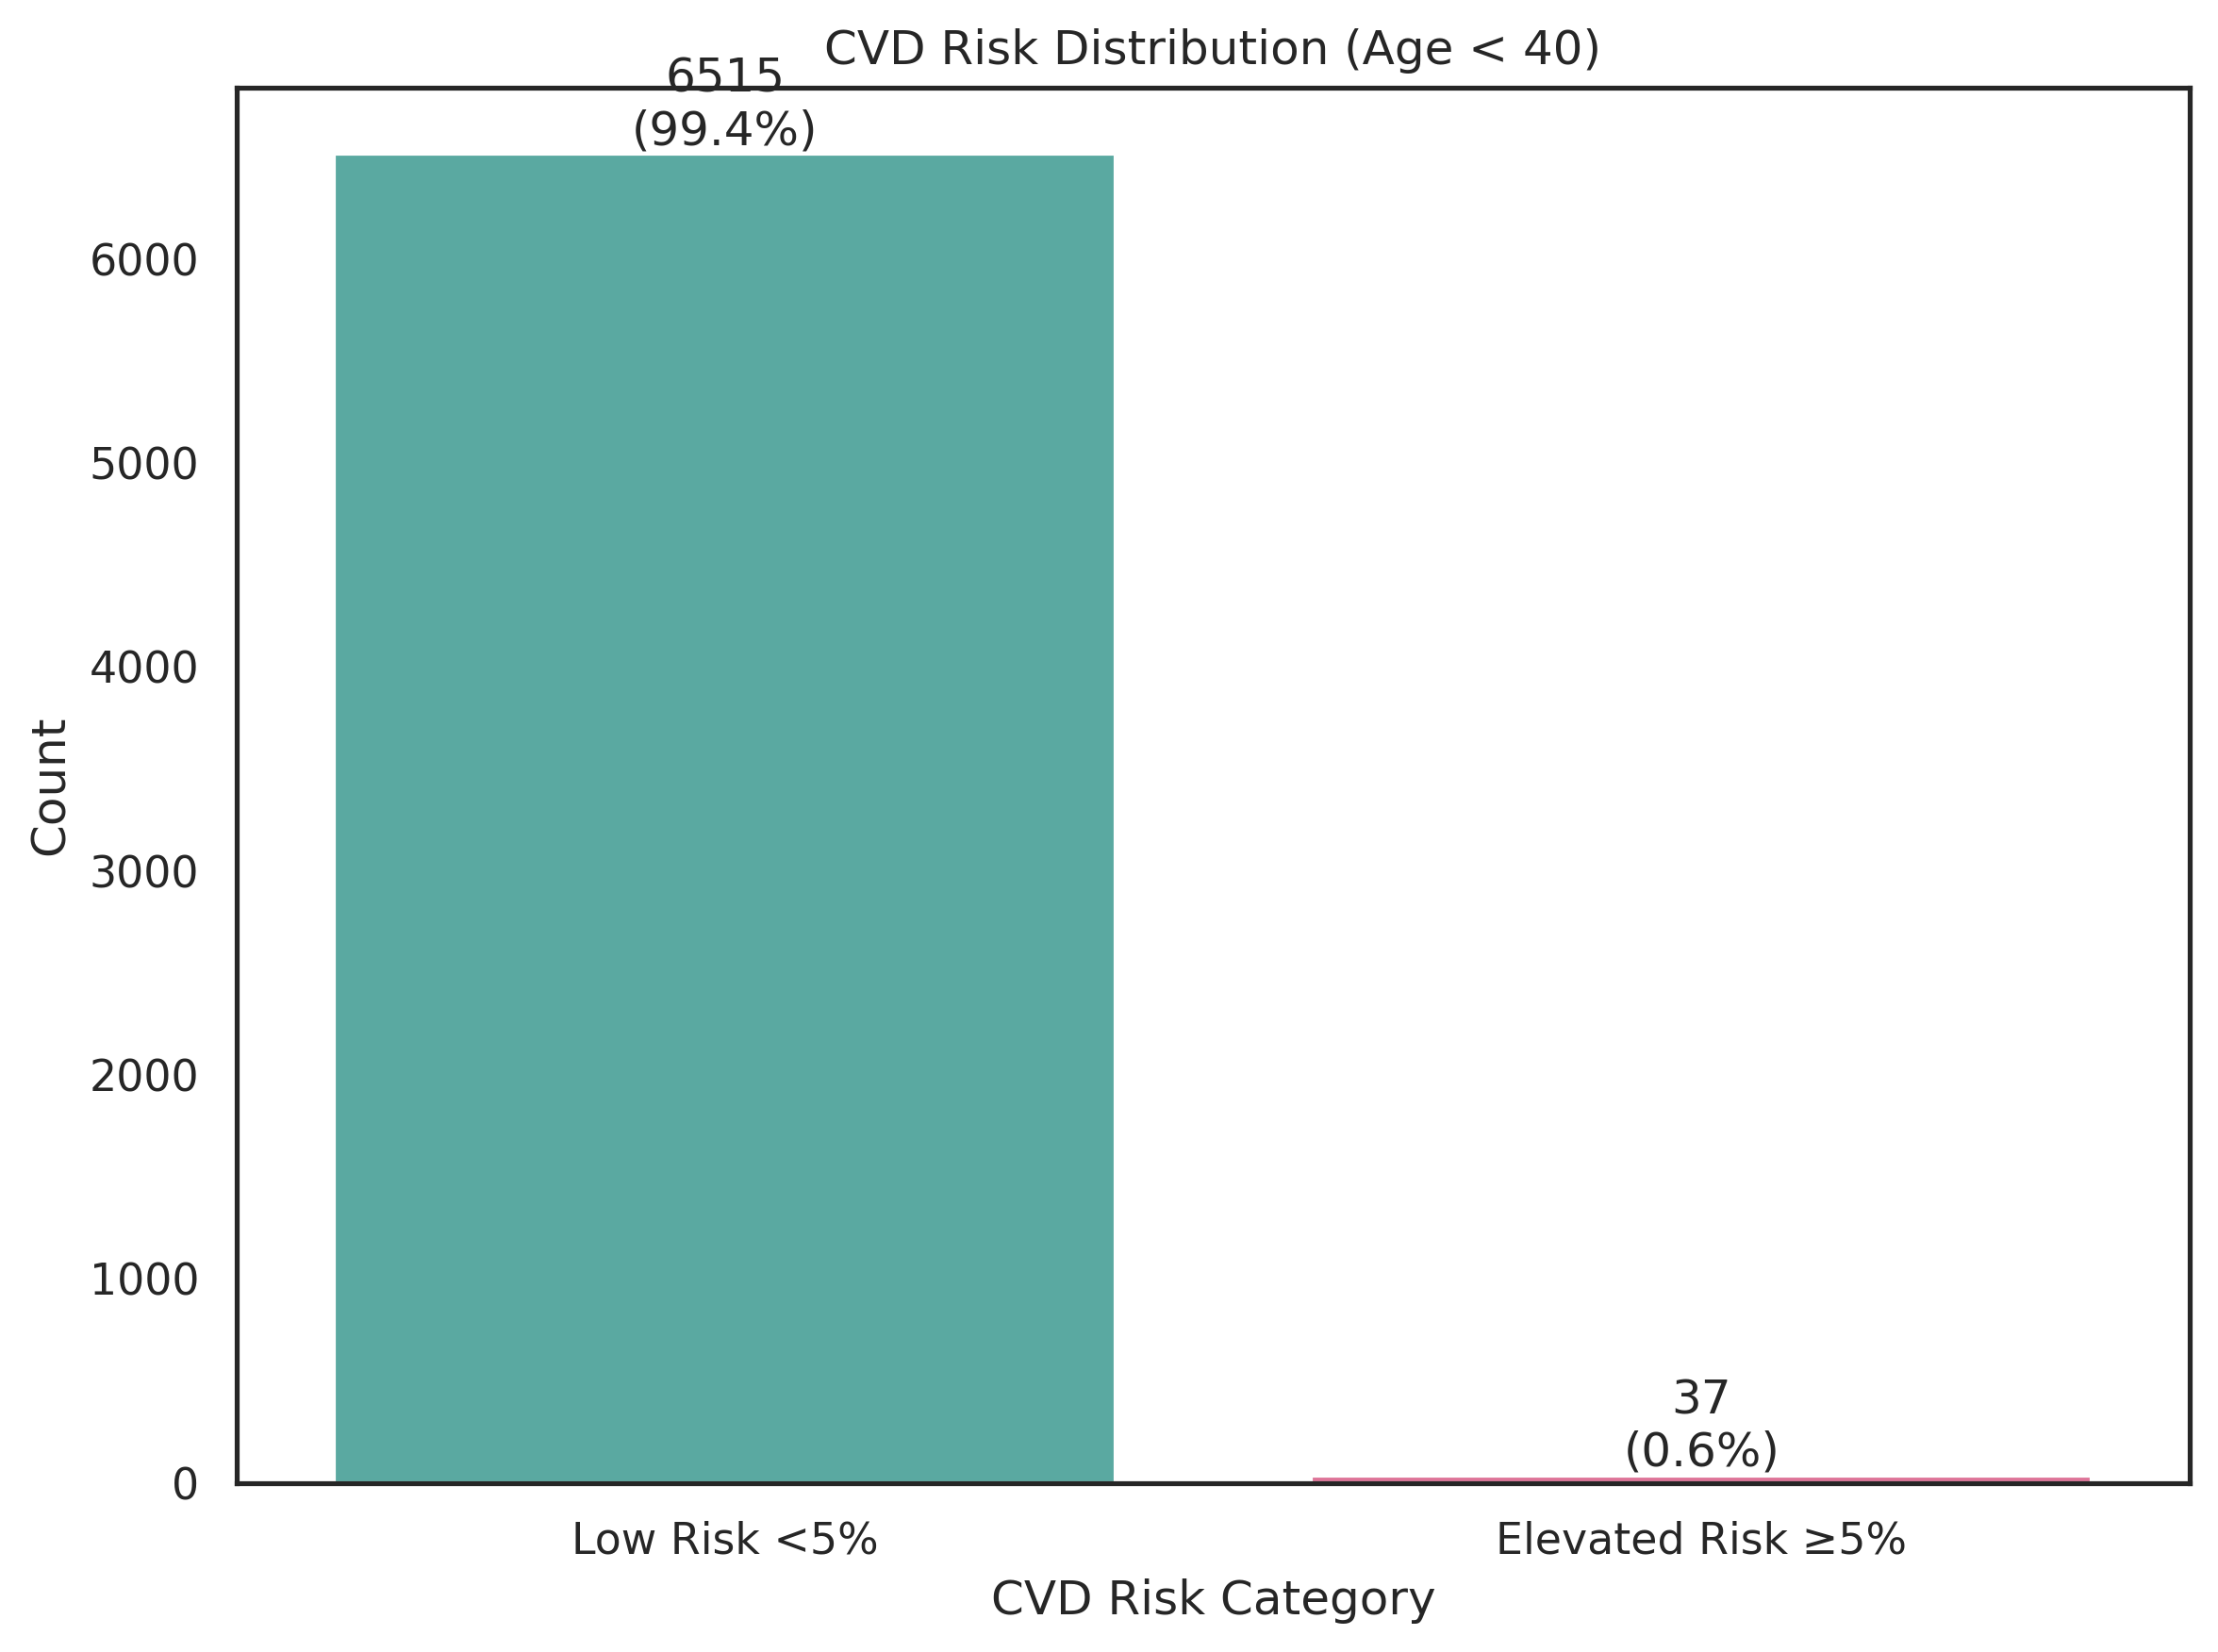

In [72]:
# === Subset: Age < 40 Bar Plot ===
young_data = sd_cvd_new[sd_cvd_new['age'] < 40]

plt.figure(figsize=(8, 6))
ax2 = sns.countplot(x='cvd_final', data=young_data, palette=colors)
plt.title('CVD Risk Distribution (Age < 40)')
plt.xlabel('CVD Risk Category')
plt.ylabel('Count')

# Add count and percent labels
total_young = len(young_data)
for p in ax2.patches:
    count = int(p.get_height())
    percent = 100 * count / total_young
    ax2.annotate(f'{count}\n({percent:.1f}%)',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')

ax2.set_xticklabels([label_map.get(int(label.get_text()), label.get_text()) for label in ax2.get_xticklabels()])
plt.tight_layout()
plt.show()




/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


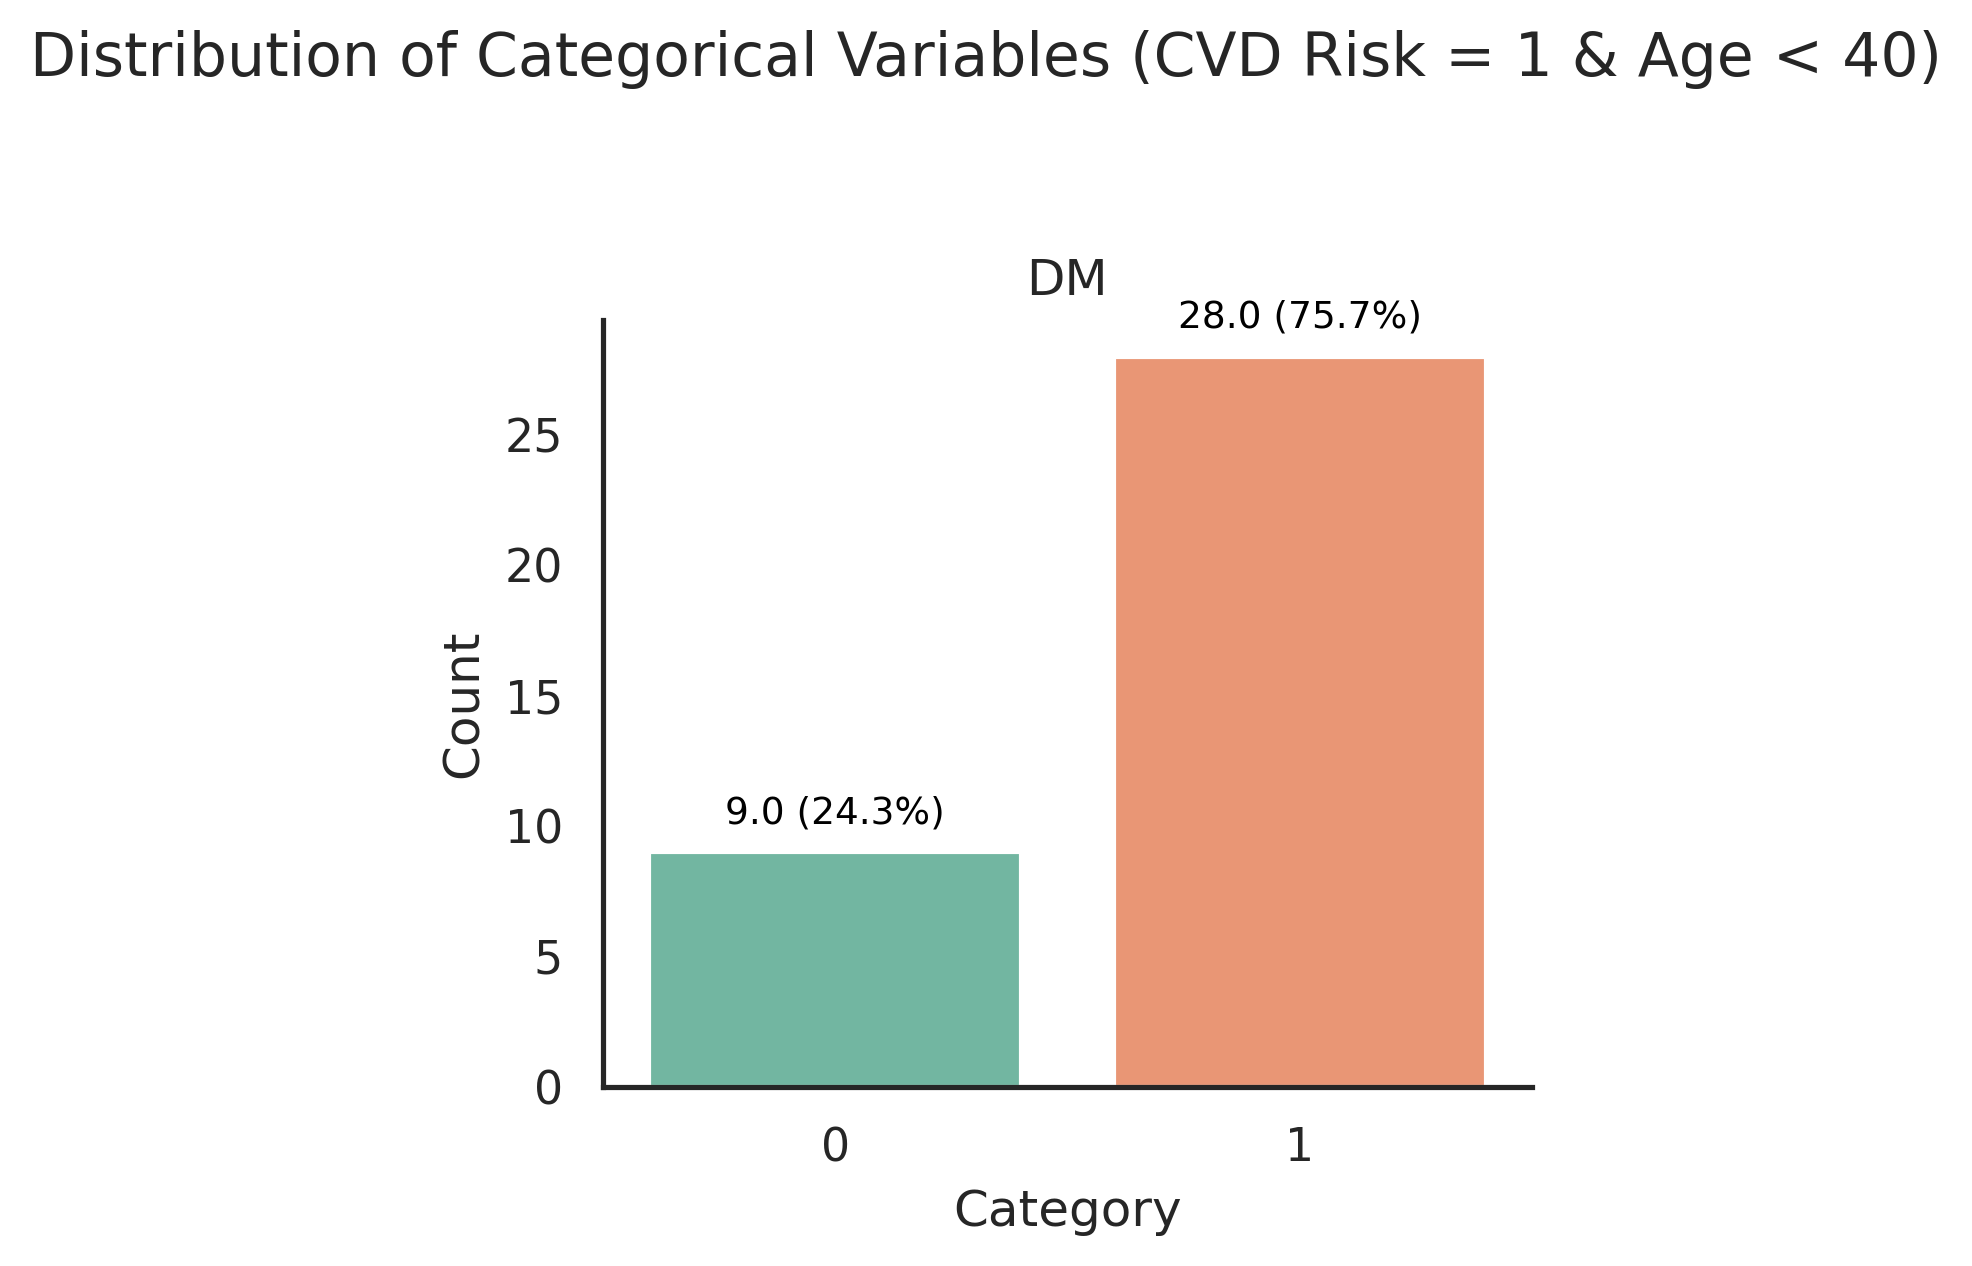

In [73]:
# Filter the subset: CVD risk = 1 and age < 40
subset = sd_cvd_new[(sd_cvd_new['cvd_final'] == 1) & (sd_cvd_new['age'] < 40)]

# ---- Bar plots for categorical variables using FacetGrid ----
cat_vars = ['DM']
subset_cat = subset[cat_vars].melt(var_name='Variable', value_name='Category')

g = sns.FacetGrid(subset_cat, col='Variable', sharey=False, height=4, aspect=1)
g.map_dataframe(sns.countplot, x='Category', palette='Set2')
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Category", "Count")

# Add count + percent labels on top of bars
for ax in g.axes.flat:
    total = sum([p.get_height() for p in ax.patches])  # total for that facet
    for p in ax.patches:
        height = p.get_height()
        percent = (height / total) * 100 if total > 0 else 0
        ax.annotate(
            f'{height} ({percent:.1f}%)',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=9, color='black', xytext=(0, 5),
            textcoords='offset points'
        )

plt.suptitle('Distribution of Categorical Variables (CVD Risk = 1 & Age < 40)', y=1.05)
plt.tight_layout()
plt.show()


In [74]:
subset = sd_cvd_new[(sd_cvd_new['cvd_final'] == 1) & (sd_cvd_new['age'] < 40)]

print("Summary statistics for individuals with CVD risk = 1 and age < 40:\n")

# Categorical summaries: count and percent

# Continuous variable: Total Cholesterol

print("\nTotal Cholesterol (mg/dL) statistics:")
print(subset['Total Cholesterol'].describe())


Summary statistics for individuals with CVD risk = 1 and age < 40:


Total Cholesterol (mg/dL) statistics:
count     37.000000
mean     196.648649
std       62.770843
min      100.000000
25%      149.000000
50%      191.000000
75%      219.000000
max      400.000000
Name: Total Cholesterol, dtype: float64


In [75]:
sd_cvd_new.to_csv("/content/drive/My Drive/STEPs survey data/final/sd_cvd_labeld_mlp.csv", encoding="utf-8", index=False)